## Fonte dos dados e dicionário

[Dados](https://www.kaggle.com/datasets/utkarshx27/breast-cancer-dataset-used-royston-and-altman)

Será utilizada, neste estudo, a base de dados intitulada "Breast Cancer Dataset 
used  by  Royston  and  Altman",  disponibilizada  na  plataforma  Kaggle.  Esse 
conjunto  de  dados  reúne  informações  clínicas de pacientes com diagnóstico 
confirmado de câncer de mama, incluindo variáveis como idade, estadiamento 
da doença, presença de metástases, entre outras características relevantes ao 
prognóstico

### Dicionário de dados

| Coluna     | Descrição                                                                 |
|------------|---------------------------------------------------------------------------|
| pid        | Identificador do paciente                                                 |
| age        | Idade, em anos                                                            |
| meno       | Status menopausal (0 = pré-menopausa, 1 = pós-menopausa)                 |
| size       | Tamanho do tumor, em milímetros                                           |
| grade      | Grau do tumor                                                             |
| nodes      | Número de linfonodos positivos                                            |
| pgr        | Receptores de progesterona (fmol/l)                                       |
| er         | Receptores de estrogênio (fmol/l)                                         |
| hormon     | Terapia hormonal (0 = não, 1 = sim)                                       |
| rfstime    | Tempo livre de recorrência; dias até a primeira recorrência, morte ou último acompanhamento |
| status     | 0 = vivo sem recorrência, 1 = recorrência ou morte                       |



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, WeibullFitter, LogNormalFitter, CoxPHFitter, ExponentialFitter, NelsonAalenFitter
from lifelines.plotting import qq_plot
from lifelines.statistics import logrank_test
from lifelines.utils import restricted_mean_survival_time, find_best_parametric_model
from lifelines.calibration import survival_probability_calibration

datapath = "data/gbsg.csv"

df = pd.read_csv(datapath)
df.drop(columns=['pid'], inplace=True)

In [2]:
event_col = ['status']
time_col = ['rfstime']
id_col = ['pid']

# 1. Analise exploratória dos dados

Evento em análise.
Recorrência ou morte

Censura: 
Para essa análise exploratória de dados, vale ressaltar que em todos os casos, são pacientes com nódulo positivo de câncer.



In [3]:
df.head()

,age,meno,size,grade,nodes,pgr,er,hormon,rfstime,status
0,49,0,18,2,2,0,0,0,1838,0
1,55,1,20,3,16,0,0,0,403,1
2,56,1,40,3,3,0,0,0,1603,0
3,45,0,25,3,1,0,4,0,177,0
4,65,1,30,2,5,0,36,1,1855,0


In [4]:
df.isna().sum()

age        0
meno       0
size       0
grade      0
nodes      0
pgr        0
er         0
hormon     0
rfstime    0
status     0
dtype: int64

In [5]:
df.min()

age        21
meno        0
size        3
grade       1
nodes       1
pgr         0
er          0
hormon      0
rfstime     8
status      0
dtype: int64

In [6]:
df.max()

age          80
meno          1
size        120
grade         3
nodes        51
pgr        2380
er         1144
hormon        1
rfstime    2659
status        1
dtype: int64

## 1.1. Integridade dos dados

- Verificando dados faltantes
- Verificando o tipo de dados (original)

In [7]:
df.shape

(686, 10)

In [8]:
df.isna().sum()

age        0
meno       0
size       0
grade      0
nodes      0
pgr        0
er         0
hormon     0
rfstime    0
status     0
dtype: int64

In [9]:
df.dtypes

age        int64
meno       int64
size       int64
grade      int64
nodes      int64
pgr        int64
er         int64
hormon     int64
rfstime    int64
status     int64
dtype: object

## 1.2. Explorando as features isoladamente

Analisando as features isoladamente
- Idade dos pacientes
- Status de menopausa
- Tamanho do tumor
- Grau do tumor
- Número de linfonodos positivos
- Receptores de progesterona
- Receptores de estrogênio
- Terapia hormonal
- Tempo livre de recorrência, dias até a primeira ocorrência, morte ou último acompanhamento
- Status do evento

In [10]:
def setup_axes(ax: plt.Axes, title:str, remove_spines: list | str = [], remove_xticks: bool = False, remove_yticks: bool = False, title_loc: str = 'center') -> plt.Axes:
    ax.set_title(title, loc=title_loc)
    if isinstance(remove_spines, list):
        for spine in remove_spines:
            ax.spines[spine].set_visible(False)
    elif isinstance(remove_spines, str):
        if remove_spines == 'all':
            for spine in ["top", "right", "left", "bottom"]:
                ax.spines[spine].set_visible(False)
    if remove_xticks:
        ax.set_xticks([])
    if remove_yticks:
        ax.set_yticks([])
    return ax

def create_subplot_list(fig:plt.Figure, gs: plt.GridSpec,  slices: list[tuple[slice | int, slice | int]]) -> list[plt.Axes]:
    axes = [None for _ in range(len(slices))]
    for i, s in enumerate(slices):
        axes[i] = fig.add_subplot(gs[s[0], s[1]])
    return axes

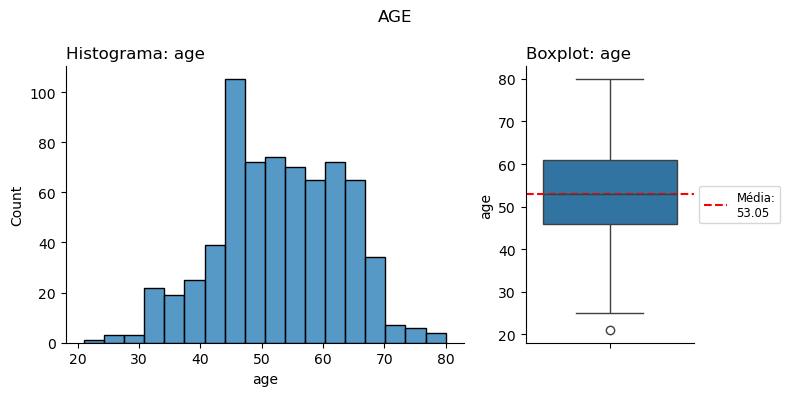

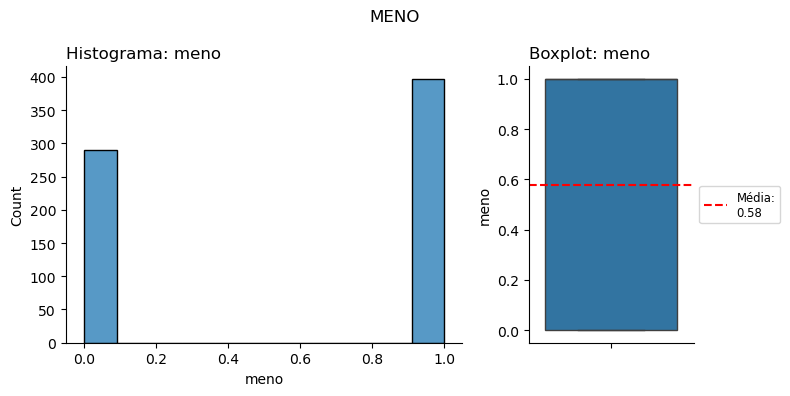

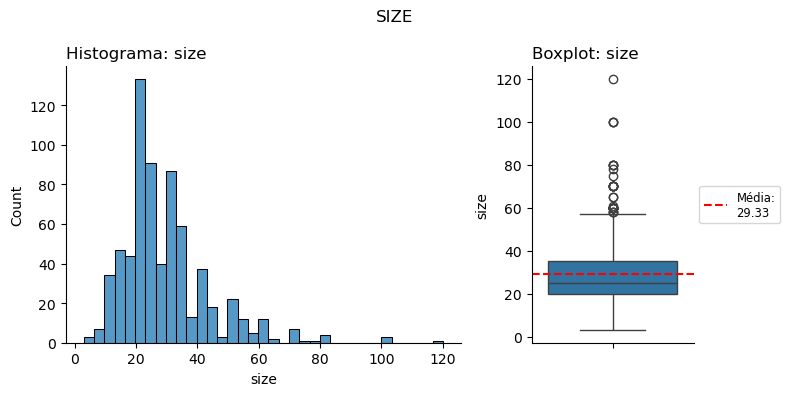

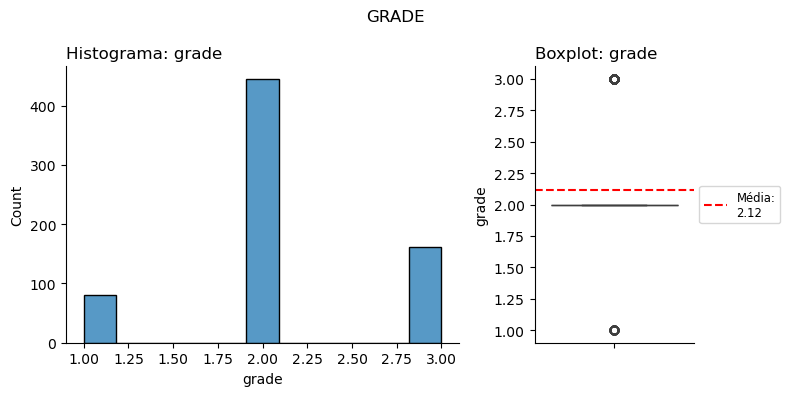

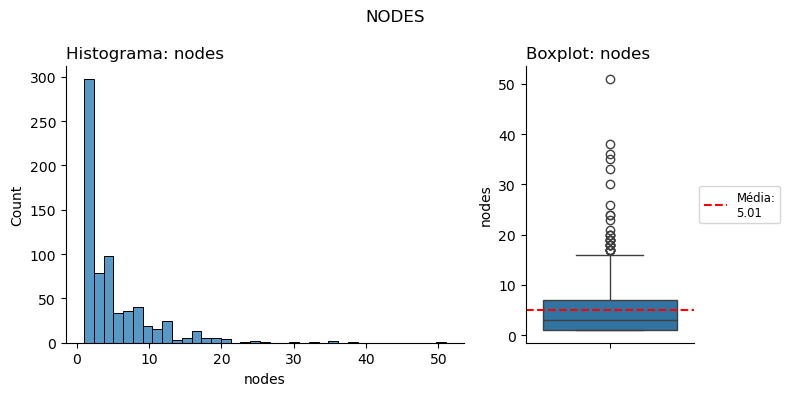

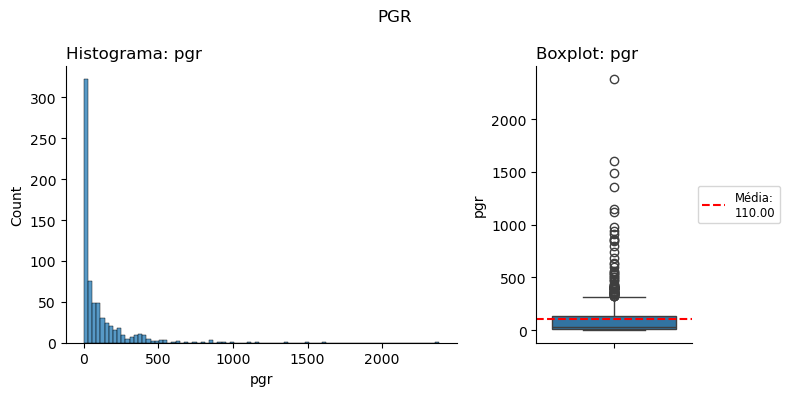

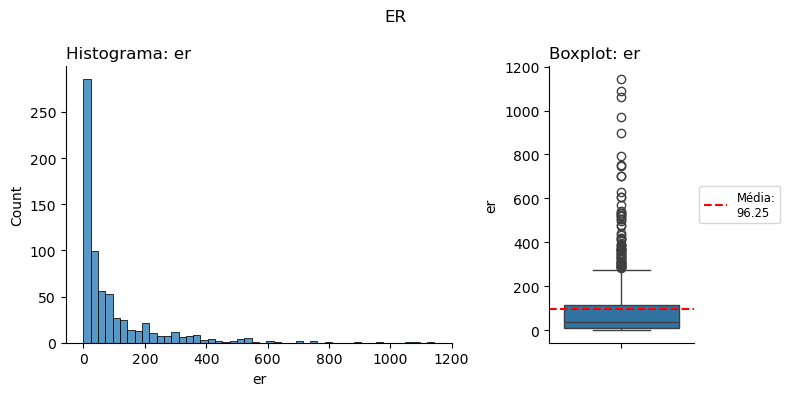

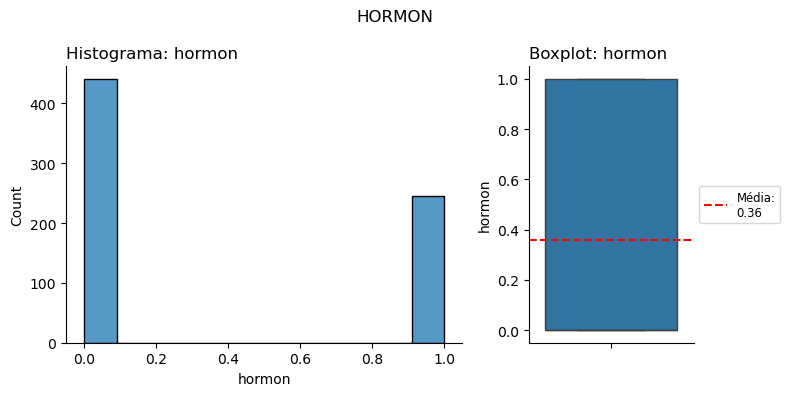

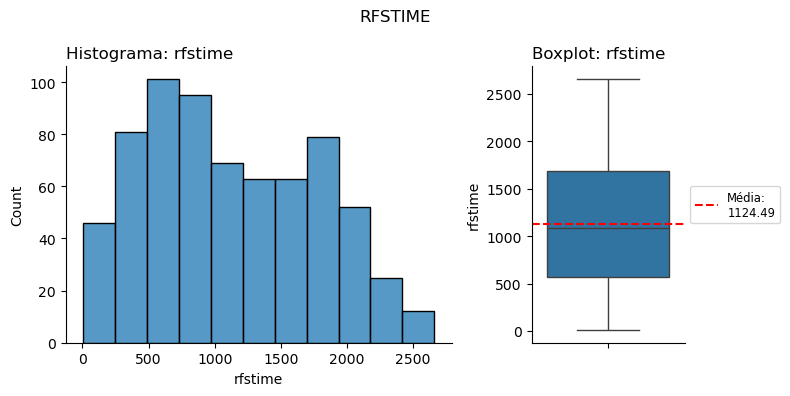

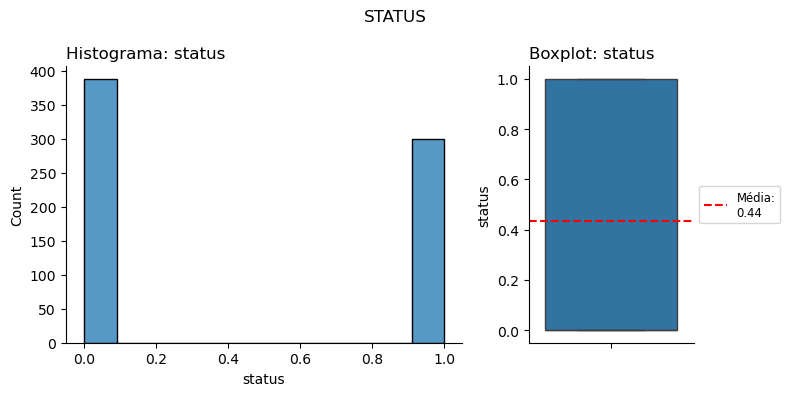

In [11]:
num_cols = ['age','meno','size', 'grade', 'nodes', 'pgr', 'er','hormon','rfstime','status']

for col in num_cols:
    fig = plt.figure(figsize=(8, 4))
    fig.suptitle(col.upper())
    
    gs = fig.add_gridspec(1, 3)
    axes = create_subplot_list(
        fig=fig,
        gs=gs,
        slices= [
            (0, slice(0,2)),
            (0, 2)
        ]
    )

    sns.histplot(df, x=col, ax=axes[0])
    sns.boxplot(df, y=col, ax=axes[1])

    mean = df[col].mean()
    axes[1].axhline(mean, color='red', linestyle='--', label=f"Média:\n{mean:.2f}")
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),  fontsize='small')

    setup_axes(axes[0], title=f"Histograma: {col}", remove_spines=['top','right'], title_loc='left')
    setup_axes(axes[1], title=f"Boxplot: {col}", remove_spines=['top','right'], title_loc='left')

    plt.tight_layout()
    plt.show()
    fig.savefig(fname=f"images/features/{col}_hist_box_plot.png")

## 1.2. Explorando a relação entre as features e o status do evento

In [12]:
# num_cols = ['age','meno','size', 'grade', 'nodes', 'pgr', 'er','hormon','rfstime','status']


# for col in num_cols:
#     fig = plt.figure(figsize=(8, 4))
#     fig.suptitle(col.upper())
#     gs = fig.add_gridspec(1, 1)
#     axes = create_subplot_list(
#         fig=fig,
#         gs=gs,
#         slices= [
#             (0, 0)
#         ]
#     )

#     sns.kdeplot(df, x=col, hue='status',ax=axes[0])
#     setup_axes(axes[0], title=f"Histograma: {col} x status", remove_spines=['top','right'], title_loc='left')

#     plt.tight_layout()
#     plt.show()
#     fig.savefig(fname=f"images/features_x_status/kde_plot_features_x_status_{col}.png")

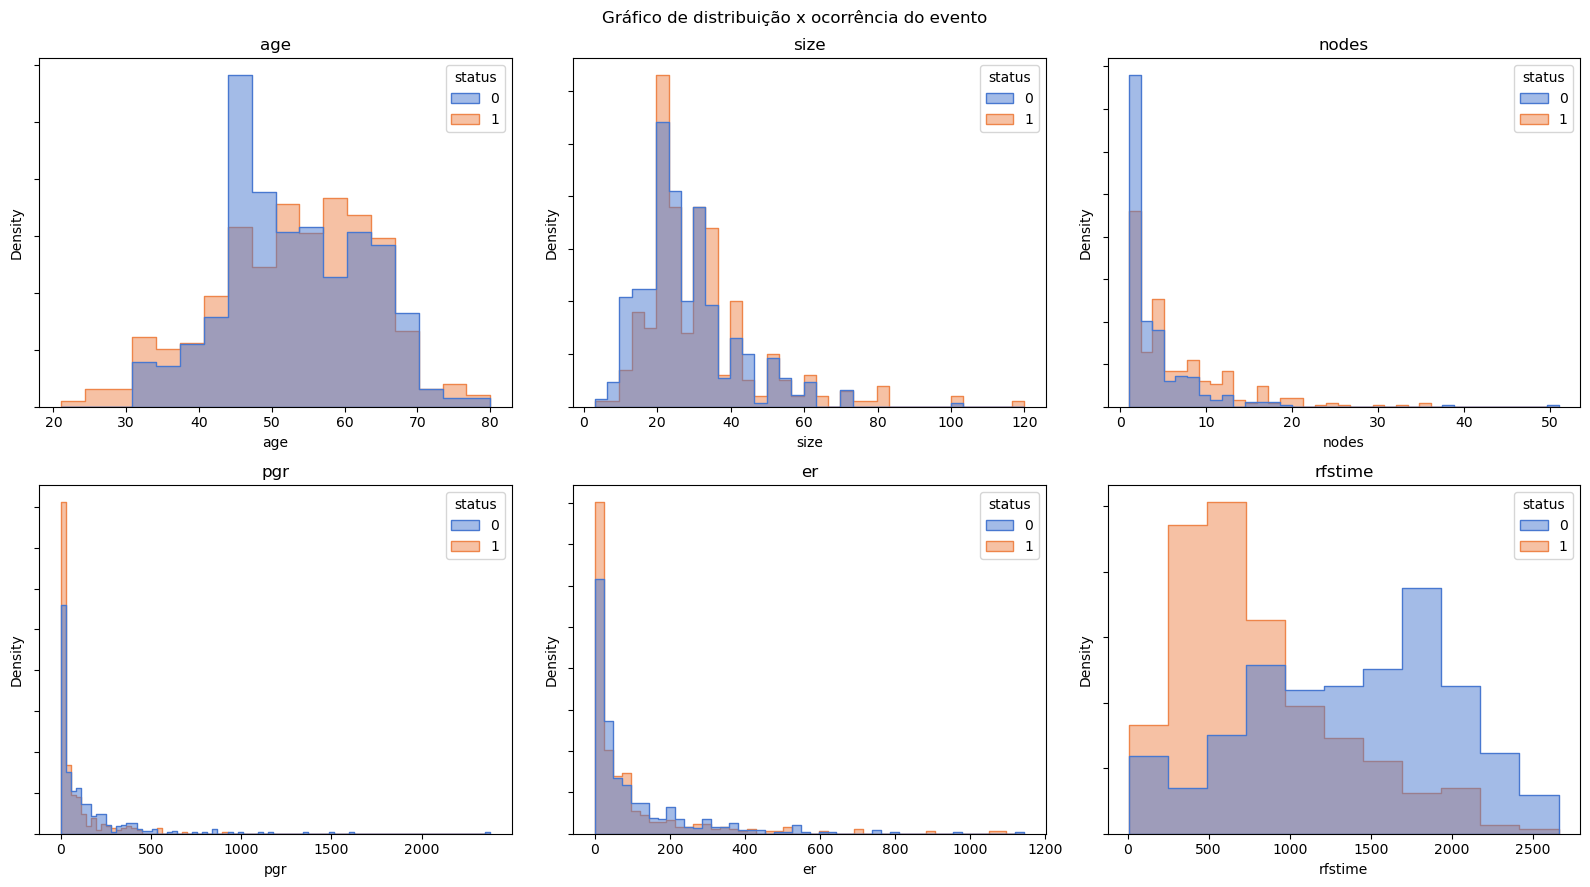

In [13]:
## Continuous columns
positions = [
        (0,0),
        (0,1),
        (0,2),
        (1,0),
        (1,1),
        (1,2)
]

columns = ['age','size','nodes', 'pgr','er','rfstime']
fig = plt.figure(figsize= (16, 9))
gs = fig.add_gridspec(2,3)
axes = create_subplot_list(
    fig=fig,
    gs=gs,
    slices=positions
)

fig.suptitle("Gráfico de distribuição x ocorrência do evento")

for i, ax in enumerate(axes):
    # Adiciona histograma
    ax.set_title(f"{columns[i]}")
    sns.histplot(
        data=df,
        x=columns[i],
        hue='status',
        stat='density',   # importante para combinar com a escala da kde
        element='step',   # você pode trocar por 'poly' ou 'bars' se quiser
        common_norm=False,  # para que cada hue tenha sua própria densidade
        palette='muted',
        ax=ax,
        alpha=0.5          # deixa mais transparente para visualizar bem a KDE
    )
    ax.set_yticklabels([])
plt.tight_layout()

In [14]:
# num_cols = ['age', 'size', 'grade', 'nodes', 'pgr', 'er', 'rfstime', 'status']

# for col in num_cols:
#     fig = plt.figure(figsize=(8, 4))
#     fig.suptitle(col.upper())
#     gs = fig.add_gridspec(1, 1)
#     axes = create_subplot_list(
#         fig=fig,
#         gs=gs,
#         slices=[(0, 0)]
#     )

#     ax = axes[0]

#     # Adiciona histograma
#     sns.histplot(
#         data=df,
#         x=col,
#         hue='status',
#         stat='density',   # importante para combinar com a escala da kde
#         element='step',   # você pode trocar por 'poly' ou 'bars' se quiser
#         common_norm=False,  # para que cada hue tenha sua própria densidade
#         palette='muted',
#         ax=ax,
#         alpha=0.3          # deixa mais transparente para visualizar bem a KDE
#     )

#     # Adiciona KDE
#     # sns.kdeplot(
#     #     data=df,
#     #     x=col,
#     #     hue='status',
#     #     common_norm=False,
#     #     ax=ax
#     # )

#     setup_axes(ax, title=f"{col} x status", remove_spines=['top', 'right'], title_loc='left')

#     plt.tight_layout()
#     plt.show()
#     fig.savefig(fname=f"images/features_x_status_no_kde/kde_hist_plot_features_x_status_{col}.png")

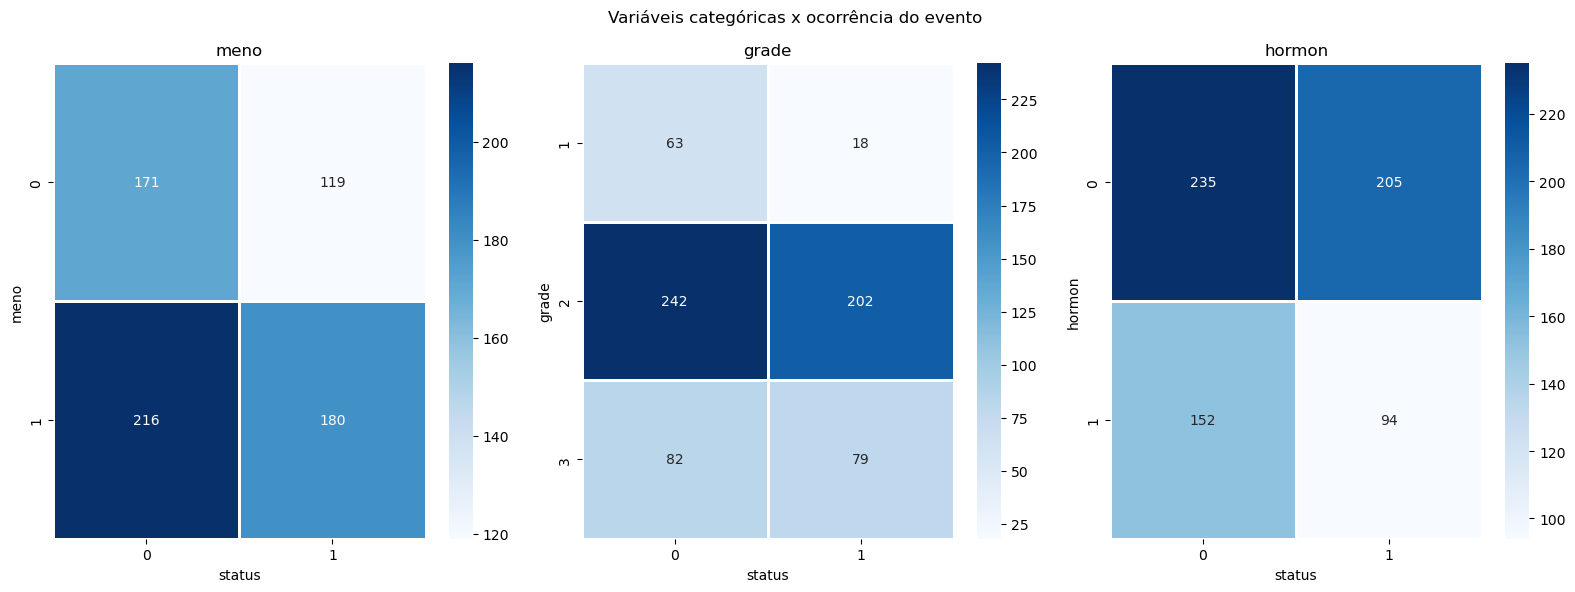

In [15]:
boolean_cols = ['meno','grade','hormon']

fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 3)
axes = create_subplot_list(
    fig=fig,
    gs=gs,
    slices= [
        (0, 0),
        (0, 1),
        (0, 2)
    ]
)
fig.suptitle("Variáveis categóricas x ocorrência do evento")
for i, ax in enumerate(axes):
    ctab = pd.crosstab(df[boolean_cols[i]], df['status'])

    sns.heatmap(ctab, annot=True, fmt=".0f", cmap="Blues", ax=ax,linecolor='white',linewidths=1)
    ax.set_title(boolean_cols[i])
    
plt.tight_layout()
plt.show()
fig.savefig(fname=f"images/heatmap_plot_cat_features_x_status.png")


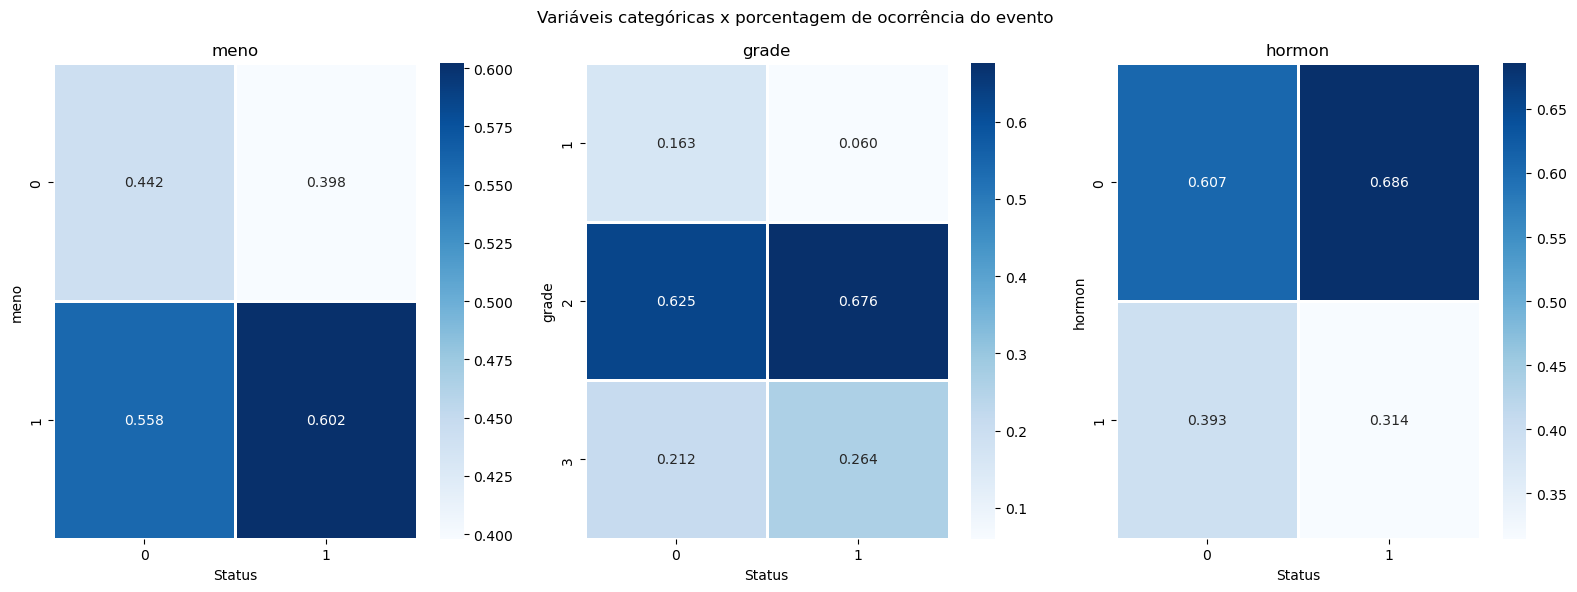

In [16]:
boolean_cols = ['meno', 'grade', 'hormon']

fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 3)
axes = create_subplot_list(
    fig=fig,
    gs=gs,
    slices=[
        (0, 0),
        (0, 1),
        (0, 2)
    ]
)

fig.suptitle("Variáveis categóricas x porcentagem de ocorrência do evento")

for i, ax in enumerate(axes):
    # Tabela cruzada com normalização por coluna (status)
    ctab = pd.crosstab(df[boolean_cols[i]], df['status'], normalize='columns')

    # Gera o heatmap com formatação em porcentagem
    sns.heatmap(ctab, annot=True, fmt=".3f", cmap="Blues", ax=ax,
                linecolor='white', linewidths=1)

    ax.set_title(boolean_cols[i])
    ax.set_xlabel('Status')
    ax.set_ylabel(boolean_cols[i])

plt.tight_layout()
plt.show()
fig.savefig(fname="images/heatmap_plot_cat_features_x_status_percent_normalized.png")

### Correlação entre variáveis

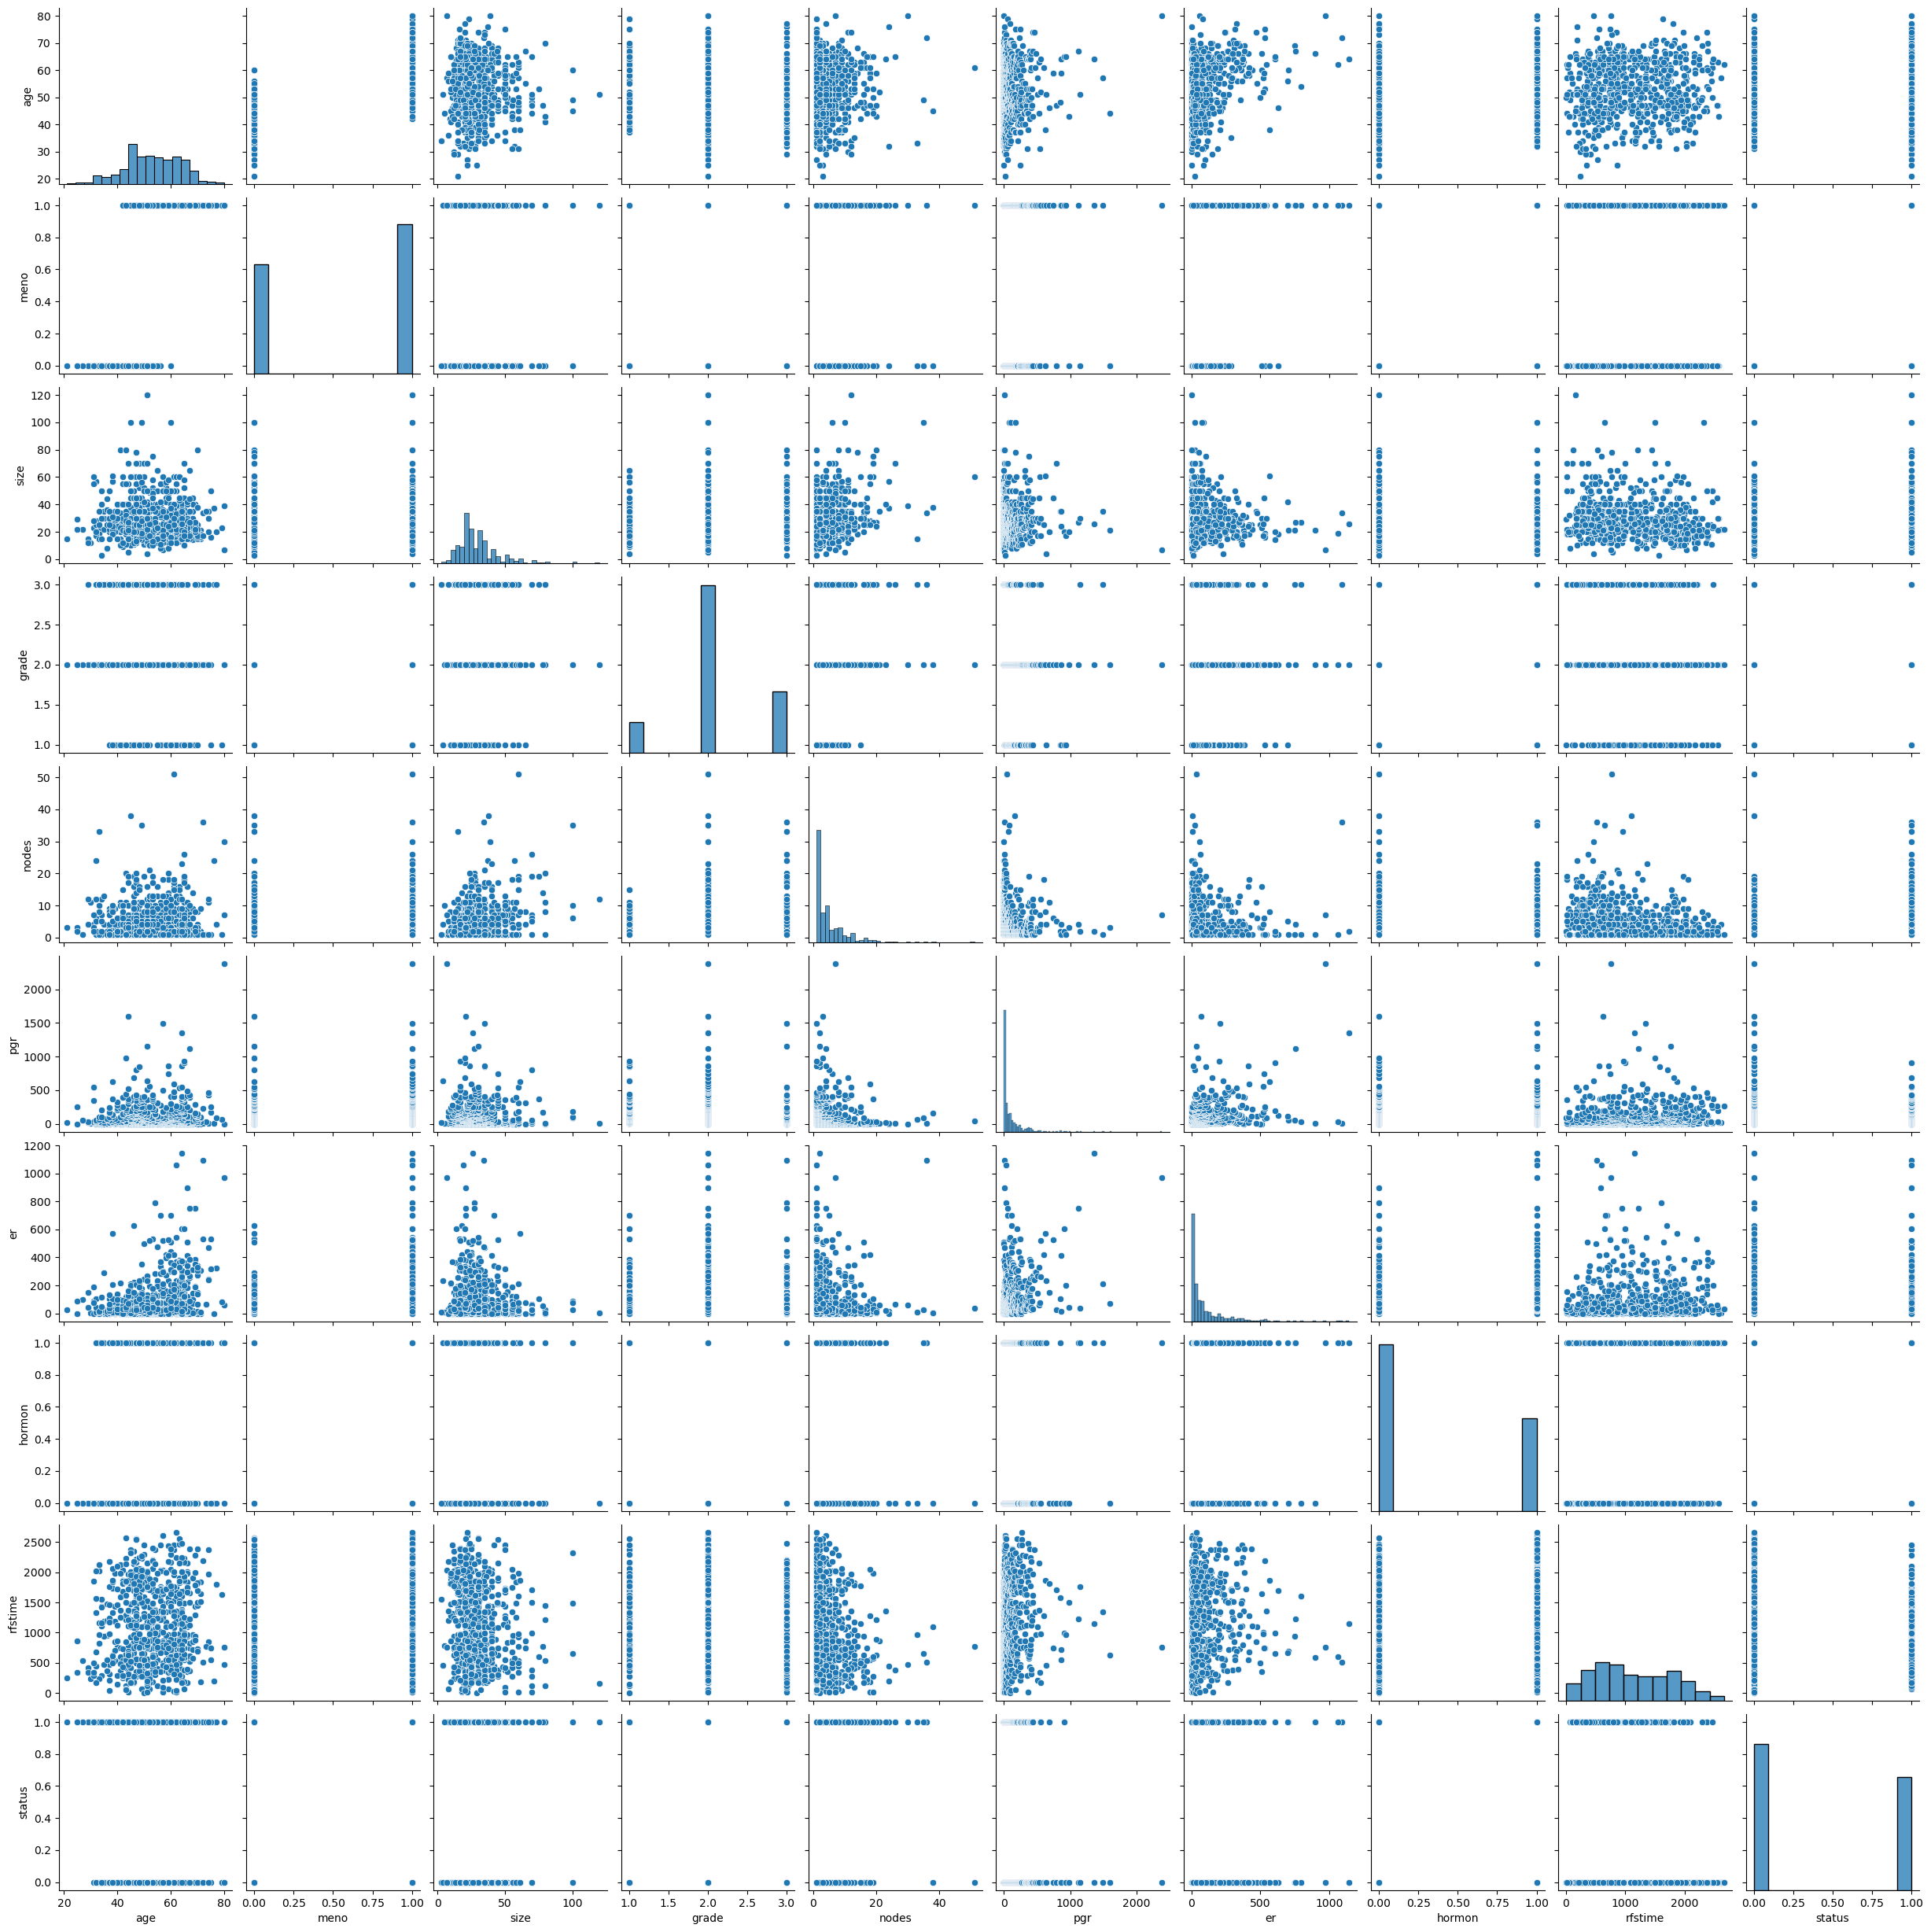

In [17]:
sns.pairplot(df)

plt.show()

# 2. Análise de sobrevivência

## Análise de sobrevivência

Entender fatores de riscos ou prognósticos para evolução e piora dos casos de câncer de mama

Caracterização do nosso problema:
1. Evento: Recidiva ou morte
2. Tempo de estudo:
    - Tempo inicial: Remoção do tumor
    - Tempo para evento ou censura: Número de dias desde a cirurgia até evento/censura
3. Censura:
    - Censura do tipo aleatório e à direita: O paciente foi removido do estudo antes da ocorrência do evento (Recuperação ou teve o último acompanhamento). O tempo máximo permitido nesse experimento é de 5 anos. Além disso, o evento de interesse está a direita do tempo registrado

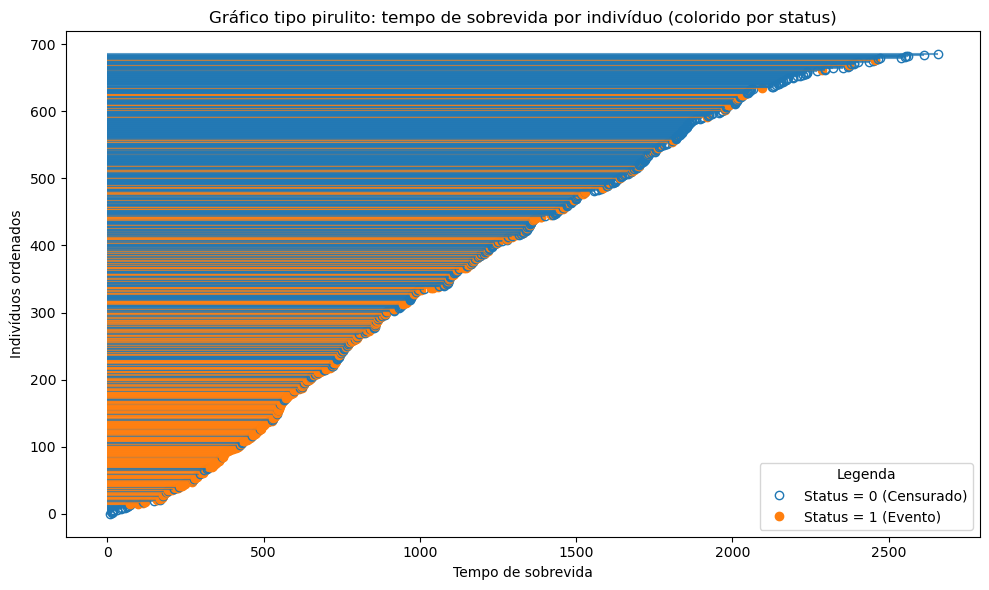

In [18]:
# Ordena os dados por tempo para um visual mais organizado
df_sorted = df.sort_values(by='rfstime').reset_index(drop=True)

# Define os valores do eixo Y como o índice dos pacientes
y_vals = df_sorted.index
x_vals = df_sorted['rfstime']
status = df_sorted['status']

fig, ax = plt.subplots(figsize=(10, 6))

# Flags para controlar se o label já foi adicionado
added_labels = {'Evento': False, 'Censurado': False}

# Desenha cada linha individualmente com a cor correspondente
for i in range(len(df_sorted)):
    color = '#ff7f0e' if status[i] == 1 else '#1f77b4'

    # Linha
    ax.hlines(y=y_vals[i], xmin=0, xmax=x_vals[i], color=color, alpha=0.7)

    # Bolinha no fim (evento = cheia, censura = vazia)
    if status[i] == 1:  # Evento
        label = 'Status = 1 (Evento)' if not added_labels['Evento'] else None
        added_labels['Evento'] = True
        ax.plot(x_vals[i], y_vals[i], 'o', color=color, label=label)
    else:  # Censura
        label = 'Status = 0 (Censurado)' if not added_labels['Censurado'] else None
        added_labels['Censurado'] = True
        ax.plot(x_vals[i], y_vals[i], 'o', markerfacecolor='none', markeredgecolor=color, label=label)

# Ajustes visuais
ax.set_xlabel('Tempo de sobrevida')
ax.set_ylabel('Indivíduos ordenados')
ax.set_title('Gráfico tipo pirulito: tempo de sobrevida por indivíduo (colorido por status)')
ax.legend(title="Legenda", loc='lower right')
plt.tight_layout()
plt.show()
fig.savefig(fname=f"images/lolipop_plot.png")

In [19]:
kmf = KaplanMeierFitter()
kmf = kmf.fit(df["rfstime"], event_observed=df["status"])

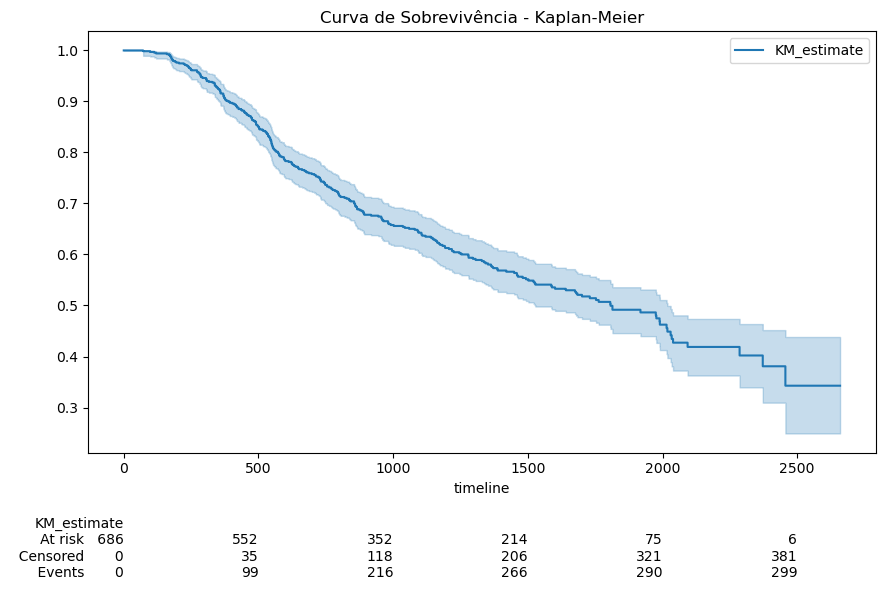

In [20]:
fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0,0])

kmf.plot_survival_function(at_risk_counts=True,  censor_styles={'ms': 6, 'marker': 's'}, ax=ax)
plt.title("Curva de Sobrevivência - Kaplan-Meier")
plt.ylabel("Probabilidade de Sobrevivência")
plt.show()

fig.savefig(fname=f"images/kaplan_meier_surv_function.png")

In [21]:
f"Estimativa de tempo {kmf.median_survival_time_} dias, em que 50% dos pacientes não terão tido recorrência ou morte. (Survived)"

'Estimativa de tempo 1807.0 dias, em que 50% dos pacientes não terão tido recorrência ou morte. (Survived)'

In [22]:
# Considerando tempo máximo = 5 anos
mean_survival_time = restricted_mean_survival_time(kmf, t=1825)
print("Tempo médio de sobrevivência estimado:", mean_survival_time)

Tempo médio de sobrevivência estimado: 1318.417104179723


In [23]:
kmf_summary_df = pd.concat([kmf.survival_function_, kmf.confidence_interval_], axis=1)

In [24]:
kmf_summary_df.tail(8)

,KM_estimate,KM_estimate_lower_0.95,KM_estimate_upper_0.95
2467.0,0.342758,0.249125,0.438274
2471.0,0.342758,0.249125,0.438274
2539.0,0.342758,0.249125,0.438274
2551.0,0.342758,0.249125,0.438274
2556.0,0.342758,0.249125,0.438274
2563.0,0.342758,0.249125,0.438274
2612.0,0.342758,0.249125,0.438274
2659.0,0.342758,0.249125,0.438274


## Comparando as curvas de sobrevivência considerando diferentes categorias

In [25]:
from itertools import combinations

In [26]:
def comparar_sobrevivencia_multigrupo(df, time_col, event_col, cat_col):
    categorias = df[cat_col].dropna().unique()
    resultados = []

    for cat_1, cat_2 in combinations(categorias, 2):
        grupo_1 = df[df[cat_col] == cat_1]
        grupo_2 = df[df[cat_col] == cat_2]

        result = logrank_test(
            durations_A=grupo_1[time_col],
            durations_B=grupo_2[time_col],
            event_observed_A=grupo_1[event_col],
            event_observed_B=grupo_2[event_col]
        )

        resultados.append({
            'cat_1': cat_1,
            'cat_2': cat_2,
            't_0': result._kwargs['t_0'],
            'p_value': result.p_value,
            'test_statistic': result.test_statistic
        })

    return pd.DataFrame(resultados)

### FEATURE: Idade

In [27]:
#bins = [0, 39, 59, float('inf')]
#labels = ['Jovem (<40)', 'Adulto (40–59)', 'Idoso (60+)']

#df['age_cat'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

In [28]:
#df['age_cat'].value_counts()

In [29]:
# grupo_col = "age_cat"  # qualquer variável categórica

# fig = plt.figure(figsize=(12,5))
# gs = fig.add_gridspec(1,2)

# ax_0= fig.add_subplot(gs[0,0])

# for grupo in df[grupo_col].unique():
#     kmf = KaplanMeierFitter()
#     mask = df[grupo_col] == grupo
#     kmf.fit(df[mask]["rfstime"], event_observed=df[mask]["status"], label=f"{grupo_col}={grupo}")
#     kmf.plot_survival_function(ax=ax_0,ci_show=False)

# plt.title(f"Curvas de Sobrevivência por {grupo_col}")
# plt.xlabel("Tempo")
# plt.ylabel("Probabilidade de Sobrevivência")
# plt.legend()


# ax_1 = fig.add_subplot(gs[0,1])
# ax_1.set_title("Contagem de pacientes por idade")
# sns.countplot(df, x='age_cat', ax=ax_1)

# plt.show()

In [30]:
# results_df = comparar_sobrevivencia_multigrupo(df=df, time_col='rfstime',event_col='status',cat_col='age_cat')

In [31]:
# results_df

### FEATURE: Meno

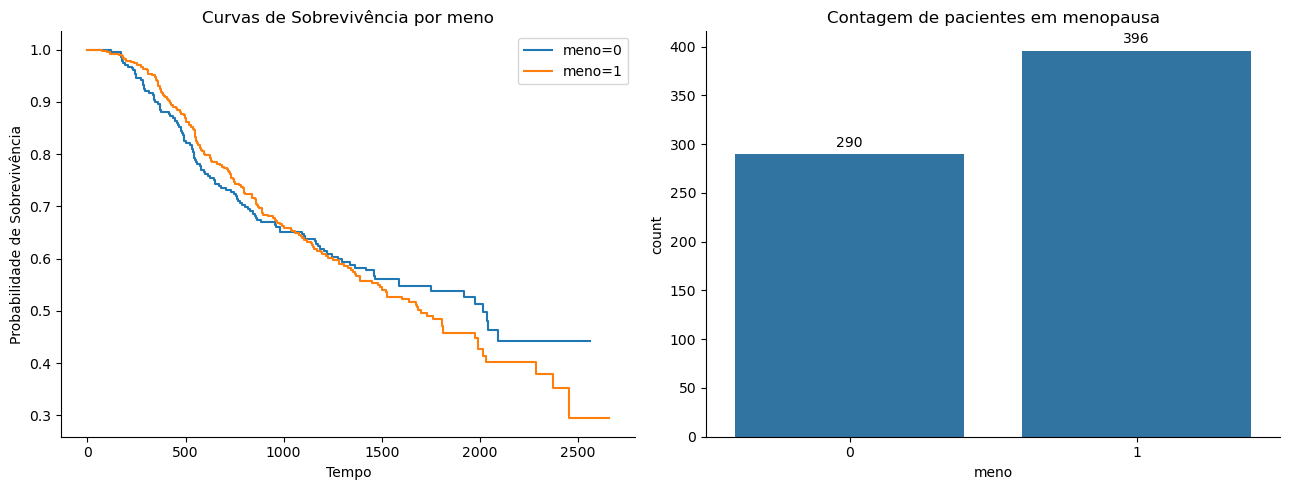

In [32]:
grupo_col = "meno"  # qualquer variável categórica

fig = plt.figure(figsize=(13, 5))
gs = fig.add_gridspec(1, 2)

# --- Curvas de sobrevivência ---
ax_0 = fig.add_subplot(gs[0, 0])

for grupo in df[grupo_col].unique():
    kmf = KaplanMeierFitter()
    mask = df[grupo_col] == grupo
    kmf.fit(df[mask]["rfstime"], event_observed=df[mask]["status"], label=f"{grupo_col}={grupo}")
    kmf.plot_survival_function(ax=ax_0, ci_show=False)

ax_0.set_title(f"Curvas de Sobrevivência por {grupo_col}")
ax_0.set_xlabel("Tempo")
ax_0.set_ylabel("Probabilidade de Sobrevivência")

ax_0.spines[['right', 'top']].set_visible(False)
ax_0.legend()

# --- Countplot ---
ax_1 = fig.add_subplot(gs[0, 1])
ax_1.set_title("Contagem de pacientes em menopausa")

bars = sns.countplot(df, x='meno', ax=ax_1)

# Adiciona rótulos acima de cada barra
for container in bars.containers:
    bars.bar_label(container, fmt='%d', label_type='edge', padding=3)
ax_1.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.show()
fig.savefig(fname=f"images/features_surv_diff_test/meno.png")

In [33]:
results_df = comparar_sobrevivencia_multigrupo(df=df, time_col='rfstime',event_col='status',cat_col='hormon')

In [34]:
results_df

,cat_1,cat_2,t_0,p_value,test_statistic
0,0,1,-1,0.003427,8.564781


In [35]:
print(results_df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & cat_1 & cat_2 & t_0 & p_value & test_statistic \\
\midrule
0 & 0 & 1 & -1 & 0.003427 & 8.564781 \\
\bottomrule
\end{tabular}



### FEATURE: Grau

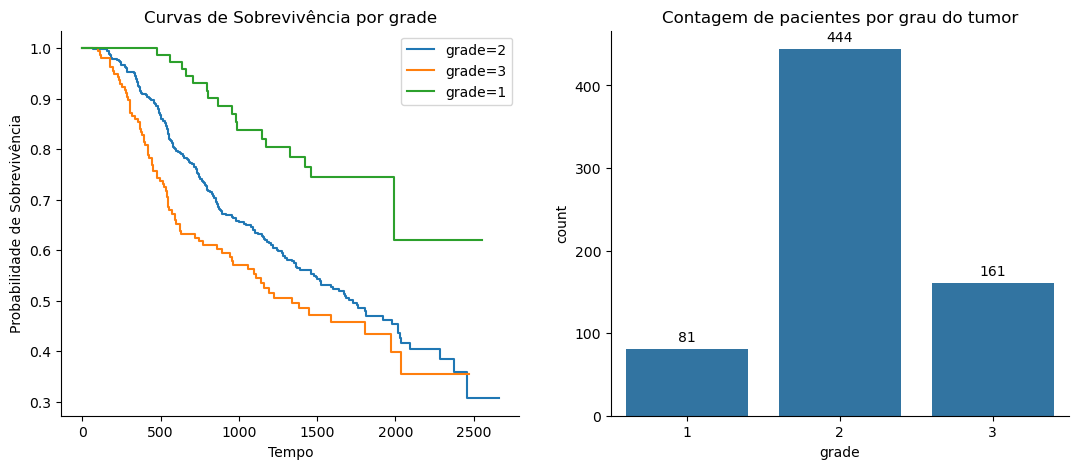

In [36]:
grupo_col = "grade"  # qualquer variável categórica

fig = plt.figure(figsize=(13, 5))
gs = fig.add_gridspec(1,2)

ax_0= fig.add_subplot(gs[0,0])

for grupo in df[grupo_col].unique():
    kmf = KaplanMeierFitter()
    mask = df[grupo_col] == grupo
    kmf.fit(df[mask]["rfstime"], event_observed=df[mask]["status"], label=f"{grupo_col}={grupo}")
    kmf.plot_survival_function(ax=ax_0,ci_show=False)

plt.title(f"Curvas de Sobrevivência por {grupo_col}")
plt.xlabel("Tempo")
plt.ylabel("Probabilidade de Sobrevivência")
ax_0.spines[['right', 'top']].set_visible(False)
ax_0.legend()

ax_1 = fig.add_subplot(gs[0,1])
ax_1.set_title("Contagem de pacientes por grau do tumor")
bars = sns.countplot(df, x='grade', ax=ax_1)
# Adiciona rótulos acima de cada barra
for container in bars.containers:
    bars.bar_label(container, fmt='%d', label_type='edge', padding=3)
ax_1.spines[['right', 'top']].set_visible(False)

plt.show()
fig.savefig(fname=f"images/features_surv_diff_test/test_grade.png")

In [37]:
results_df = comparar_sobrevivencia_multigrupo(df=df, time_col='rfstime',event_col='status',cat_col='grade')
results_df

,cat_1,cat_2,t_0,p_value,test_statistic
0,2,3,-1,0.035374,4.427015
1,2,1,-1,0.000218,13.671903
2,3,1,-1,0.000009,19.815191


In [38]:
print(results_df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & cat_1 & cat_2 & t_0 & p_value & test_statistic \\
\midrule
0 & 2 & 3 & -1 & 0.035374 & 4.427015 \\
1 & 2 & 1 & -1 & 0.000218 & 13.671903 \\
2 & 3 & 1 & -1 & 0.000009 & 19.815191 \\
\bottomrule
\end{tabular}



### FEATURE: Tratamento hormonal

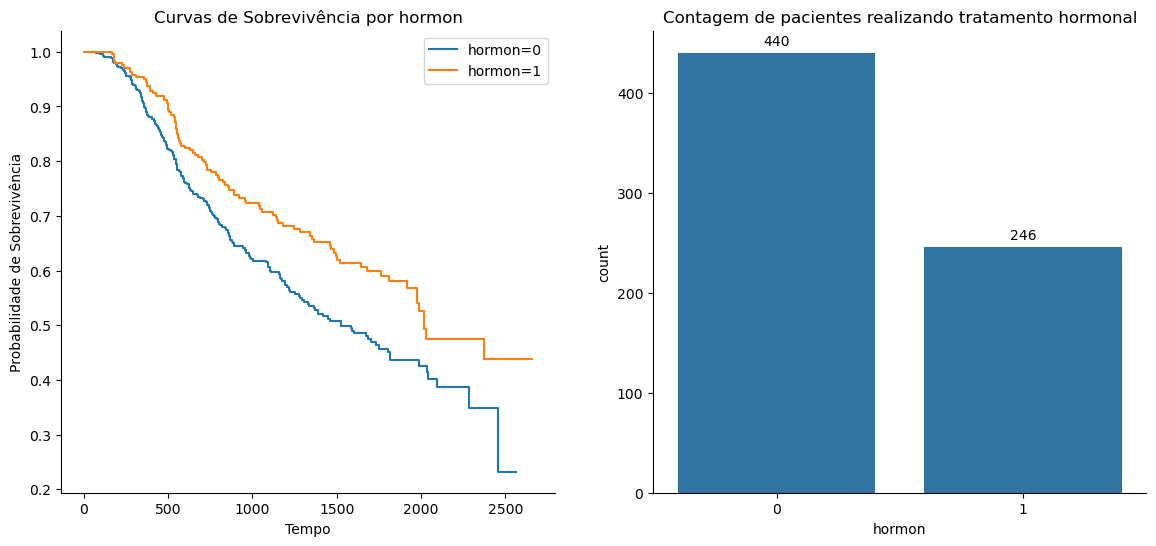

In [39]:
grupo_col = "hormon"  # qualquer variável categórica

fig = plt.figure(figsize=(14,6))
gs = fig.add_gridspec(1,2)

ax_0= fig.add_subplot(gs[0,0])

for grupo in df[grupo_col].unique():
    kmf = KaplanMeierFitter()
    mask = df[grupo_col] == grupo
    kmf.fit(df[mask]["rfstime"], event_observed=df[mask]["status"], label=f"{grupo_col}={grupo}")
    kmf.plot_survival_function(ax=ax_0,ci_show=False)

plt.title(f"Curvas de Sobrevivência por {grupo_col}")
plt.xlabel("Tempo")
plt.ylabel("Probabilidade de Sobrevivência")
ax_0.spines[['right', 'top']].set_visible(False)
ax_0.legend()

ax_1 = fig.add_subplot(gs[0,1])
ax_1.set_title("Contagem de pacientes realizando tratamento hormonal")
bars = sns.countplot(df, x=grupo_col, ax=ax_1)
for container in bars.containers:
    bars.bar_label(container, fmt='%d', label_type='edge', padding=3)
ax_1.spines[['right', 'top']].set_visible(False)
plt.show()
fig.savefig(fname=f"images/features_surv_diff_test/test_hormon.png")

In [40]:
results_df = comparar_sobrevivencia_multigrupo(df=df, time_col='rfstime',event_col='status',cat_col=grupo_col)
results_df

,cat_1,cat_2,t_0,p_value,test_statistic
0,0,1,-1,0.003427,8.564781


In [41]:
print(results_df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & cat_1 & cat_2 & t_0 & p_value & test_statistic \\
\midrule
0 & 0 & 1 & -1 & 0.003427 & 8.564781 \\
\bottomrule
\end{tabular}



## Métodos paramétricos

In [42]:
# Dados
T = df["rfstime"]           # tempo até o evento ou censura
E = df["status"]            # 1 = evento ocorreu, 0 = censurado

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

# Exponencial
print ("======")
exp = ExponentialFitter()
exp.fit(T, event_observed=E)
exp.print_summary()

# Weibull
print ("======")
wf = WeibullFitter()
wf.fit(T, event_observed=E)
wf.print_summary()

# Log-Normal
print ("======")
lnf = LogNormalFitter()
lnf.fit(T, event_observed=E)
lnf.print_summary()

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 686 total observations, 387 right-censored observations>
   number of observations = 686
number of events observed = 299
           log-likelihood = -2647.80
               hypothesis = lambda_ != 0

---
           coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 2579.93    149.20         2287.50         2872.36

         cmp to     z      p  -log2(p)
lambda_    0.00 17.29 <0.005    220.13
---
AIC = 5297.60

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 686 total observations, 387 right-censored observations>
   number of observations = 686
number of events observed = 299
           log-likelihood = -2637.28
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 2259.85    114.89         2034.68         2485.03
rho_       1.27      0.06            1.15            1.40

         cmp to     z      p  -log2(p)
lambda_    1.00 19.66 <0.005    283.48
rho_       1.00  4.29 <0.005     15.78
---
AIC = 5278.55

<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 686 total observations, 387 right-censored observations>
   number of observations = 686
number of events observed = 299
           log-likelihood = -2618.89
               hypothesis = mu_ != 0, sigma_ != 1

---
        coef  se(coef)  coef lower 95%  coef upper 95%
mu_     7.42      0.06            7.31            7.53
sigma_  1.11      0.05            1.02            1.21

        cmp to      z      p  -log2(p)
mu_       0.00 131.50 <0.005       inf
sigma_    1.00   2.28   0.02      5.47
---
AIC = 5241.77

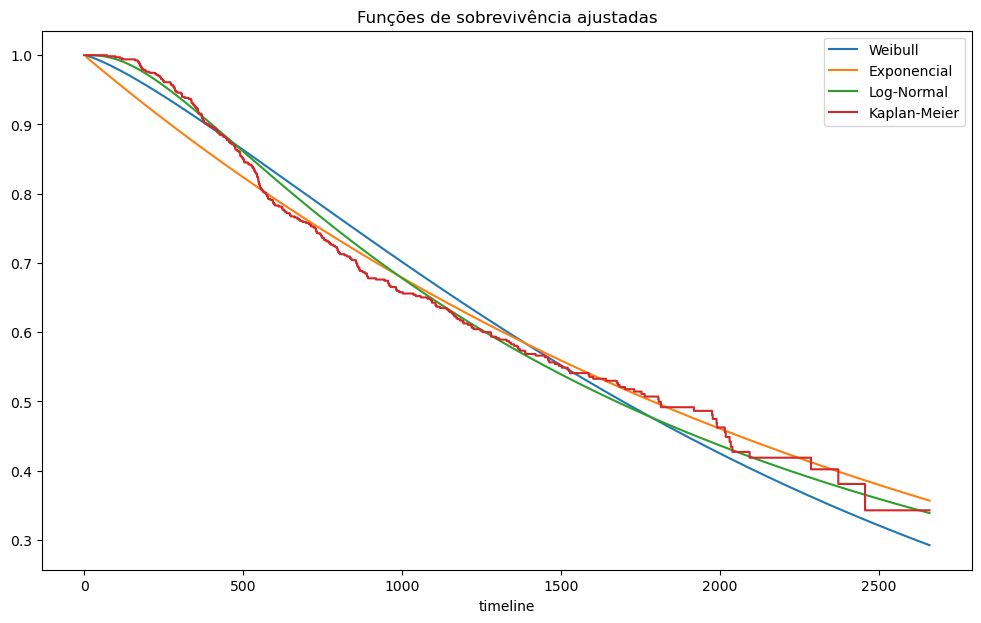

In [43]:
fig = plt.figure(figsize=(12,7))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0,0])

wf.plot_survival_function(label="Weibull", ax=ax,ci_show=False)
exp.plot_survival_function(label="Exponencial", ax=ax, ci_show=False)
lnf.plot_survival_function(label="Log-Normal", ax=ax,ci_show=False)
kmf.plot_survival_function(label="Kaplan-Meier", ax=ax,ci_show=False)

plt.title("Funções de sobrevivência ajustadas")
plt.legend()
plt.show()
fig.savefig(fname=f"images/parametric/all_models.png")

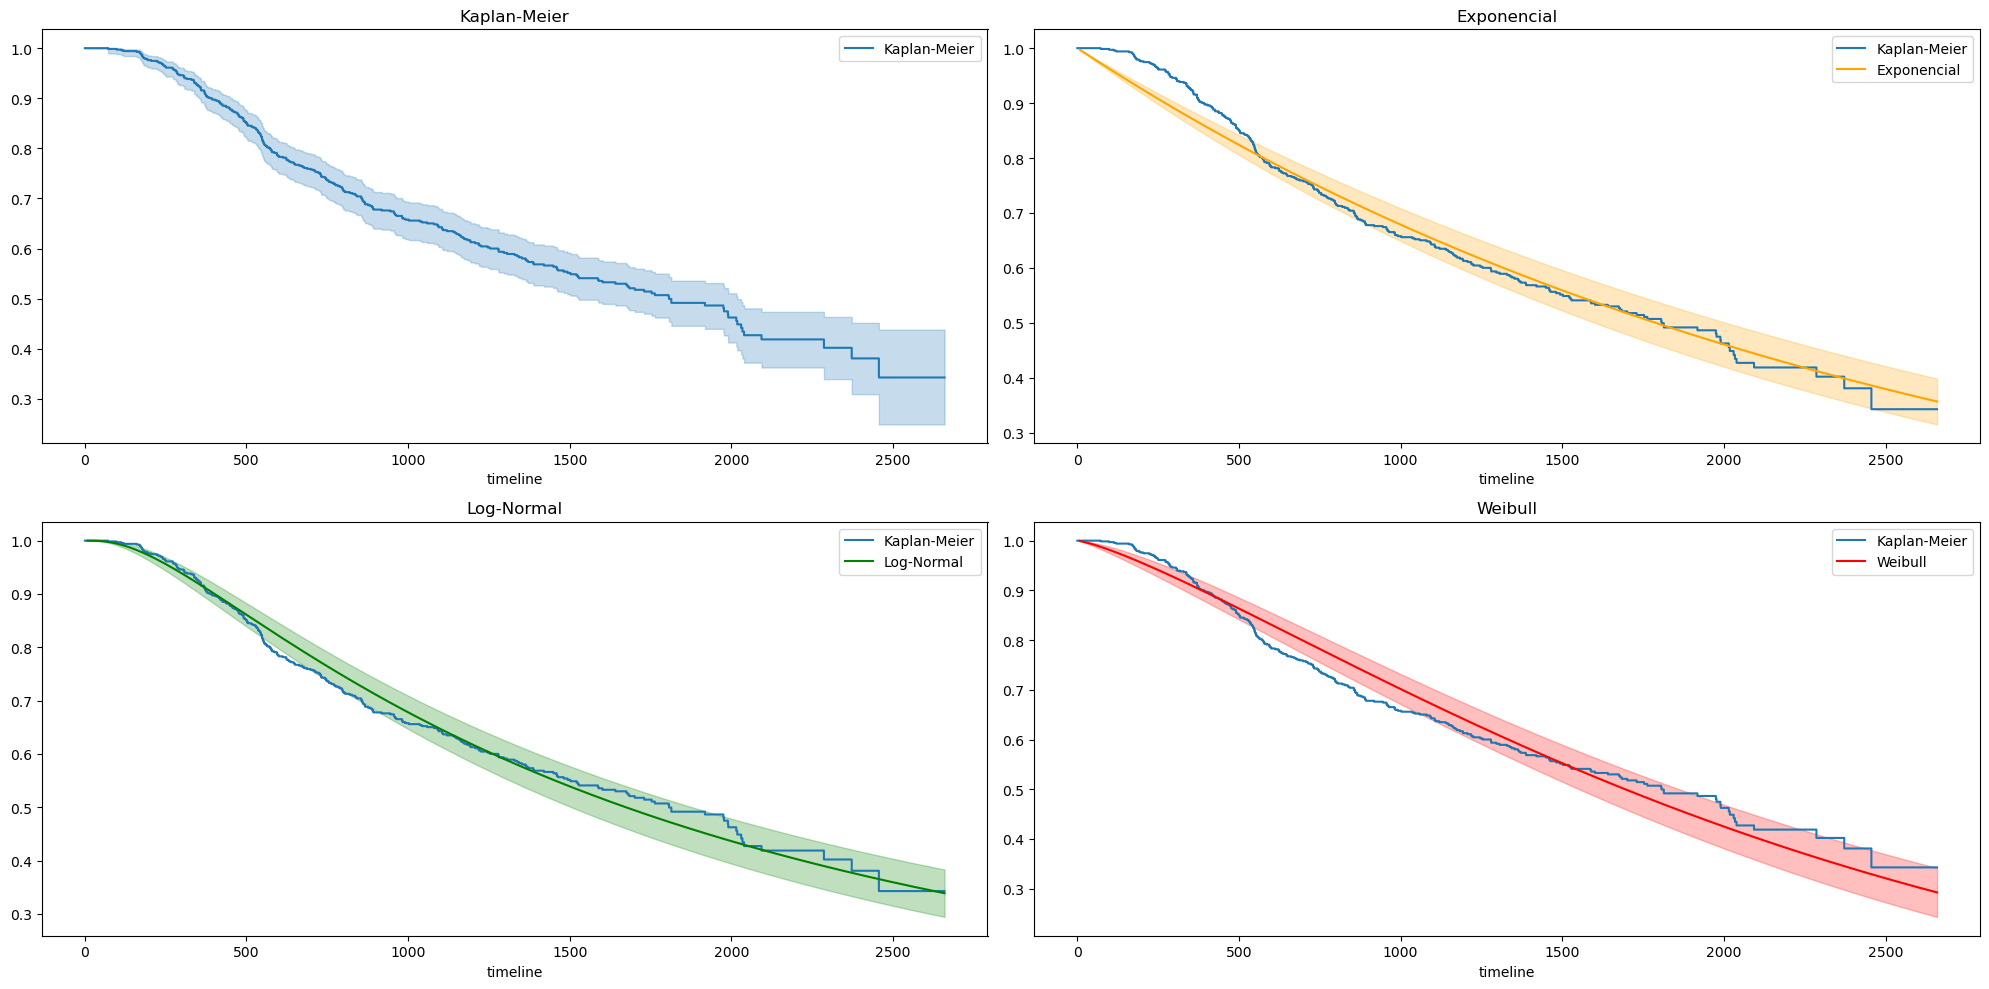

In [44]:
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(2,2)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("Kaplan-Meier")
kmf.plot_survival_function(label="Kaplan-Meier", ax=ax0,ci_show=True)

ax1 = fig.add_subplot(gs[0,1])
ax1.set_title("Exponencial")
kmf.plot_survival_function(label="Kaplan-Meier", ax=ax1,ci_show=False)
exp.plot_survival_function(label="Exponencial", ax=ax1, ci_show=True, color='orange')


ax2 = fig.add_subplot(gs[1,0])
ax2.set_title("Log-Normal")
kmf.plot_survival_function(label="Kaplan-Meier", ax=ax2,ci_show=False)
lnf.plot_survival_function(label="Log-Normal", ax=ax2,ci_show=True, color='green')


ax3 = fig.add_subplot(gs[1,1])
ax3.set_title("Weibull")
kmf.plot_survival_function(label="Kaplan-Meier", ax=ax3,ci_show=False)
wf.plot_survival_function(label="Weibull", ax=ax3,ci_show=True, color='red')

plt.tight_layout()
plt.legend()
plt.show()

fig.savefig(fname=f"images/parametric/all_models_separeted.png")

In [45]:
# Tempos onde a função de sobrevivência é definida
times = kmf.survival_function_.index

# Valores das funções de sobrevivência
S_km = kmf.survival_function_["KM_estimate"].values
S_exp = exp.survival_function_at_times(times).values
S_wf = wf.survival_function_at_times(times).values
S_logn = lnf.survival_function_at_times(times).values


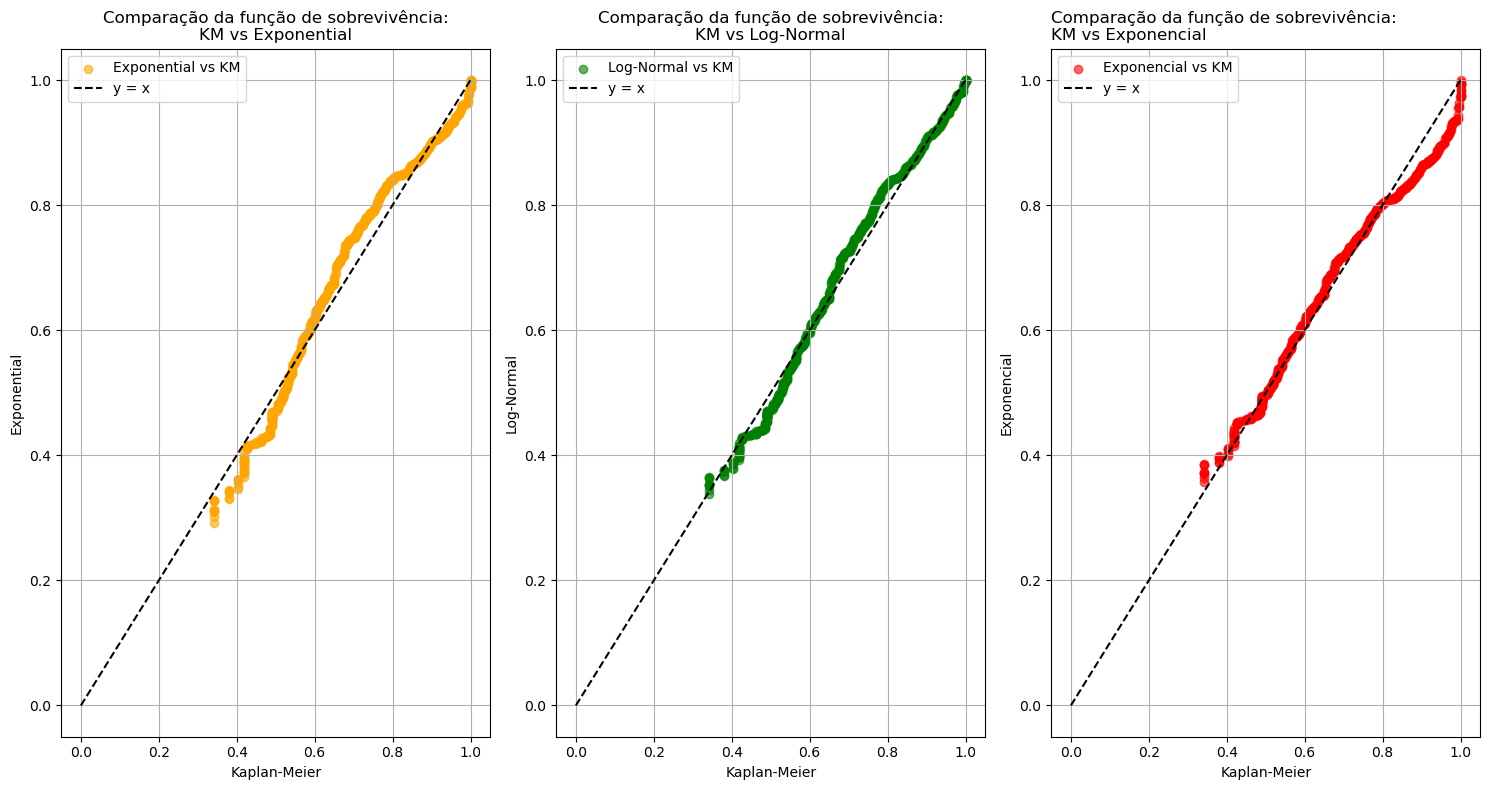

In [46]:
# KM vs Exponential
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(1,3)
ax_0 = fig.add_subplot(gs[0,0])

ax_0.scatter(S_km, S_wf, alpha=0.6, label="Exponential vs KM", color='orange')
ax_0.plot([0, 1], [0, 1], 'k--', label='y = x')
ax_0.set_xlabel("Kaplan-Meier")
ax_0.set_ylabel("Exponential")
ax_0.set_title("Comparação da função de sobrevivência:\nKM vs Exponential")
ax_0.legend()
ax_0.grid(True)

# KM vs Log-Normal
ax_1 = fig.add_subplot(gs[0,1])
ax_1.scatter(S_km, S_logn, alpha=0.6, label="Log-Normal vs KM", color='green')
ax_1.plot([0, 1], [0, 1], 'k--', label='y = x')
ax_1.set_xlabel("Kaplan-Meier")
ax_1.set_ylabel("Log-Normal")
ax_1.set_title("Comparação da função de sobrevivência:\nKM vs Log-Normal")
ax_1.legend()
ax_1.grid(True)

# KM vs Exponencial
ax_2 = fig.add_subplot(gs[0,2])
ax_2.scatter(S_km, S_exp, alpha=0.6, label="Exponencial vs KM", color='red')
ax_2.plot([0, 1], [0, 1], 'k--', label='y = x')
ax_2.set_xlabel("Kaplan-Meier")
ax_2.set_ylabel("Exponencial")
ax_2.set_title("Comparação da função de sobrevivência:\nKM vs Exponencial", loc='left', )
ax_2.legend()
ax_2.grid(True)

plt.tight_layout()
plt.show()

fig.savefig(fname=f"images/parametric/models_x_km.png")

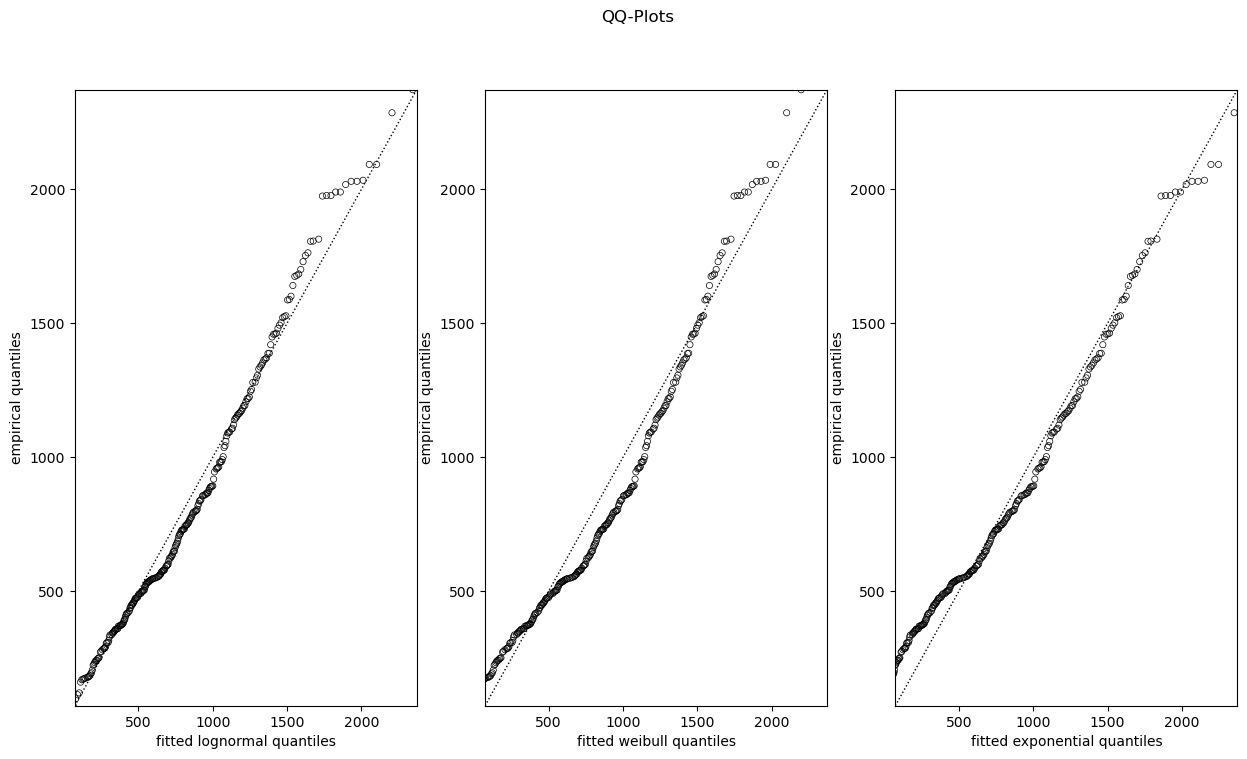

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes = axes.reshape(3,)

fig.suptitle("QQ-Plots")
for i, model in enumerate([lnf, wf, exp]):
    qq_plot(model, ax=axes[i])
    
fig.savefig(fname=f"images/parametric/qq-plot.png")

<lifelines.SplineFitter:"SplineFitter: 2 internal knot", fitted with 686 total observations, 387 right-censored observations>


<Axes: >

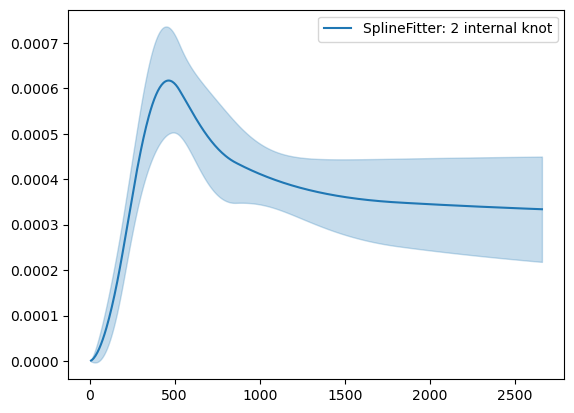

In [48]:
best_model, best_aic_ = find_best_parametric_model(T, E, scoring_method="AIC")

print(best_model)

best_model.plot_hazard()

## Modelos paramétricos - AFT

In [ ]:
from lifelines import WeibullAFTFitter, LogLogisticAFTFitter, LogNormalAFTFitter, GeneralizedGammaRegressionFitter
from lifelines.utils import k_fold_cross_validation

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

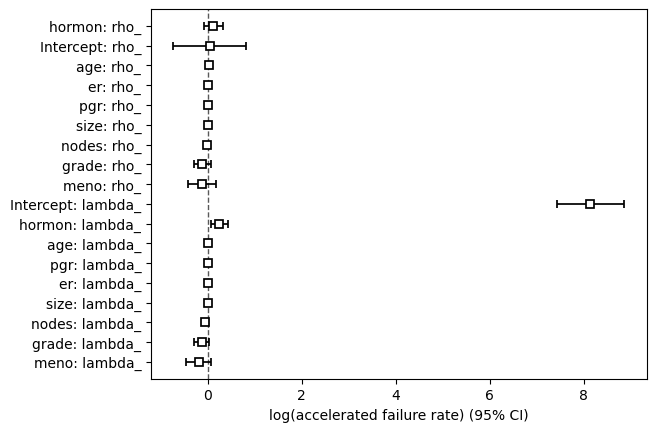

In [ ]:
wft = WeibullAFTFitter()
loglogistic = LogLogisticAFTFitter()
lognormal = LogNormalAFTFitter()
gammareg = GeneralizedGammaRegressionFitter()

wft = wft.fit(df, 'rfstime', 'status', ancillary=True)
loglogistic = loglogistic.fit(df, 'rfstime', 'status', ancillary=True)
lognormal = lognormal.fit(df, 'rfstime', 'status', ancillary=True)
gammareg = gammareg.fit(df, 'rfstime', 'status', ancillary=True)

## Regressão de Cox

In [49]:
from lifelines.statistics import proportional_hazard_test

### Incorporando todas as features

In [50]:
if 'age_cat' in df.columns:
    df = df.drop(columns='age_cat')

In [51]:
cph = CoxPHFitter()
cph.fit(df, duration_col='rfstime', event_col='status')

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>

In [52]:
results = proportional_hazard_test(cph, df, time_transform='rank')
results.print_summary()

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
         test_name = proportional_hazard_test

---
        test_statistic    p  -log2(p)
age               2.67 0.10      3.29
er                1.31 0.25      1.99
grade             5.60 0.02      5.80
hormon            0.18 0.67      0.57
meno              0.02 0.88      0.19
nodes             0.70 0.40      1.31
pgr               1.27 0.26      1.94
size              0.24 0.62      0.68

Avaliando as features com maior HR


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
         test_name = proportional_hazard_test

---
             test_statistic    p  -log2(p)
age    km              2.78 0.10      3.39
       rank            2.67 0.10      3.29
er     km              0.91 0.34      1.56
       rank            1.31 0.25      1.99
grade  km              4.43 0.04      4.82
       rank            5.60 0.02      5.80
hormon km              0.17 0.68      0.55
       rank            0.18 0.67      0.57
meno   km              0.01 0.92      0.13
       rank            0.02 0.88      0.19
nodes  km              0.72 0.40      1.34
       rank            0.70 0.40      1.31
pgr    km              1.39 0.24      2.07
       rank            1.27 0.26      1.94
size   km              0.24 0.62      0.68
       rank            0.24 0.62      0.68



1. Variable 'grade' failed the non-proportional test: p-value is 0.0179.

   Advice: with so few unique values (only 3), you can include `strata=['grade', ...]` in the call
in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/e

[[<Axes: xlabel='rank-transformed time\n(p=0.1021)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0952)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8767)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9156)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6230)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6236)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0179)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0353)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4037)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3957)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2599)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2386)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2515)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3392)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6746)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6811)'>]]

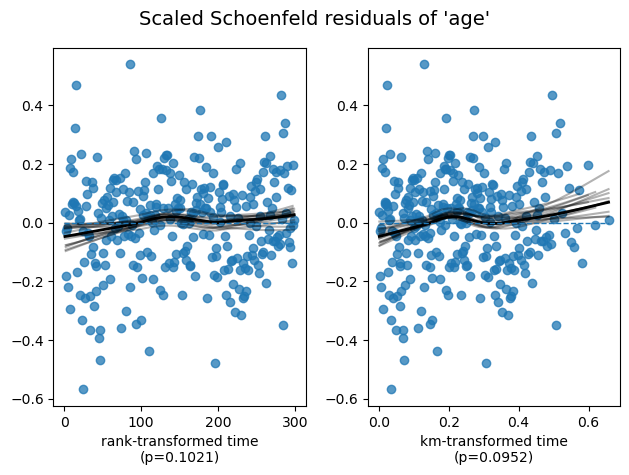

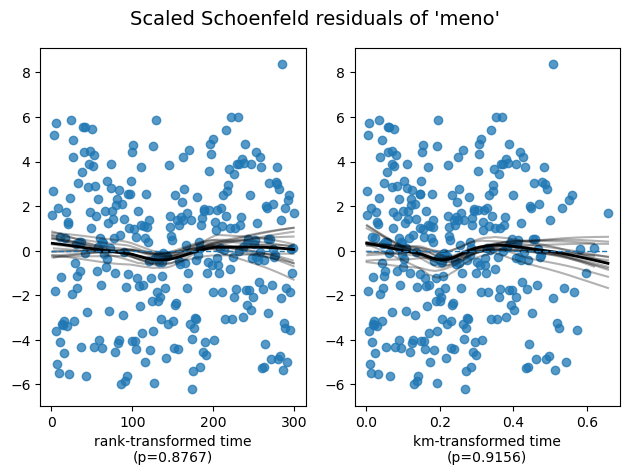

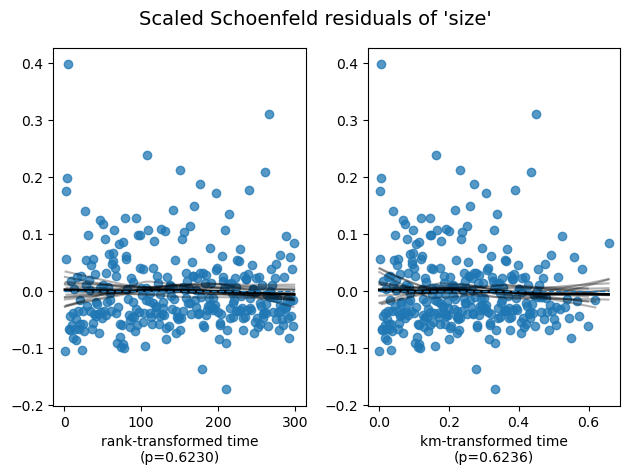

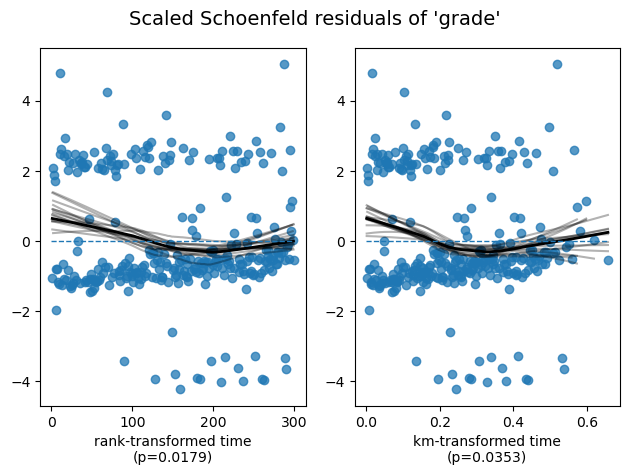

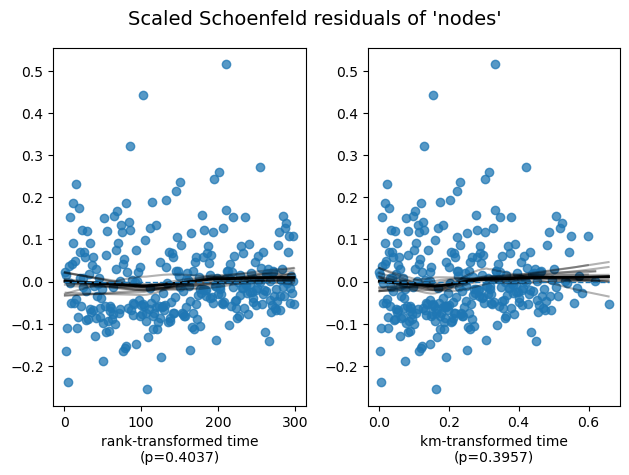

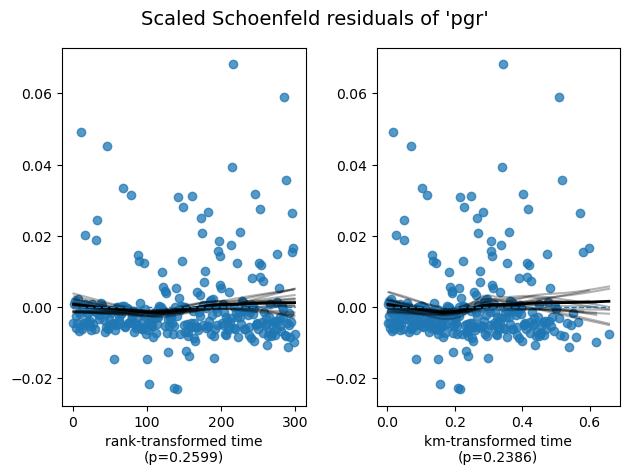

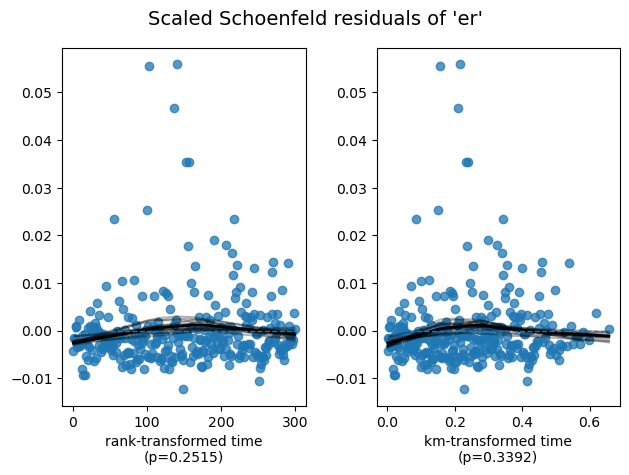

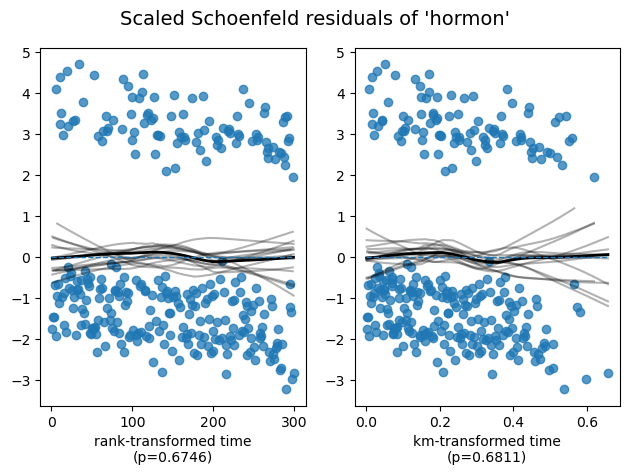

In [53]:
cph = CoxPHFitter()
cph.fit(df, duration_col='rfstime', event_col='status')
cph.check_assumptions(df, p_value_threshold=0.05, show_plots=True)

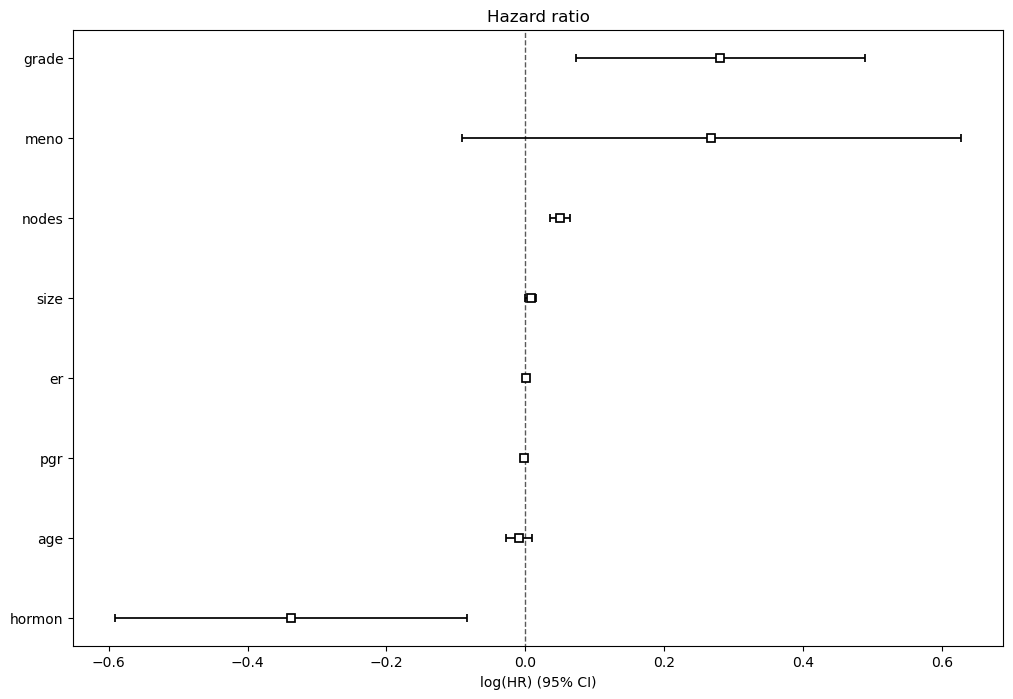

In [54]:
fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0,0])

ax.set_title("Hazard ratio")
cph.plot(ax=ax)
fig.savefig("images/cox/all_features_hazard_ratios_strat.png")

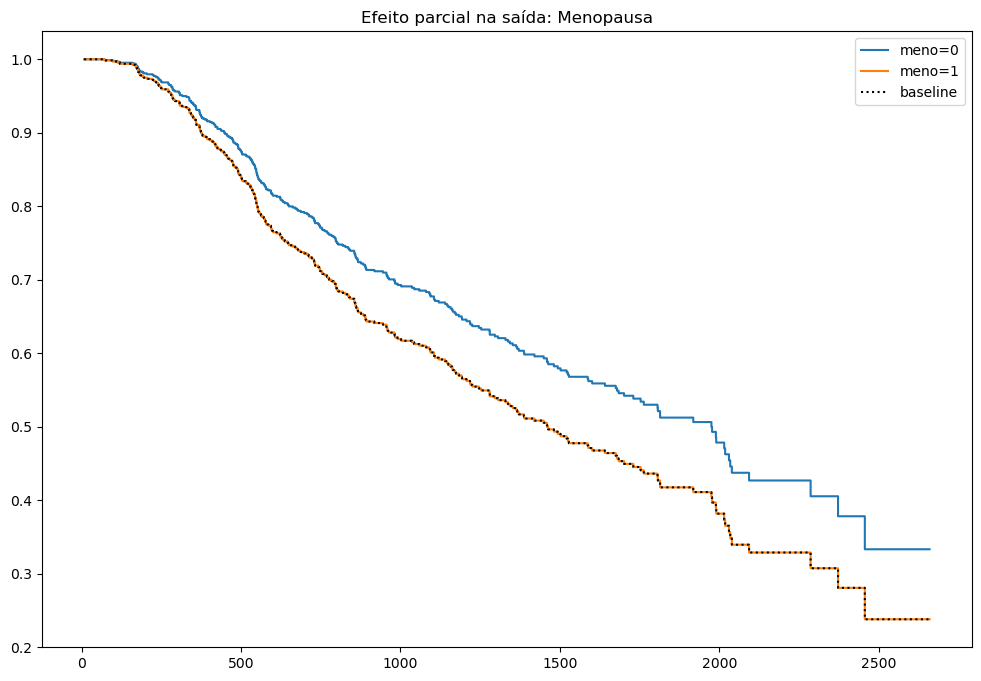

In [55]:
fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(1,1)
ax=fig.add_subplot(gs[0,0])

ax.set_title("Efeito parcial na saída: Menopausa")
cph.plot_partial_effects_on_outcome(covariates='meno', values=[0, 1], ax=ax)
plt.show()
fig.savefig(f"images/cox/partial_meno.png")

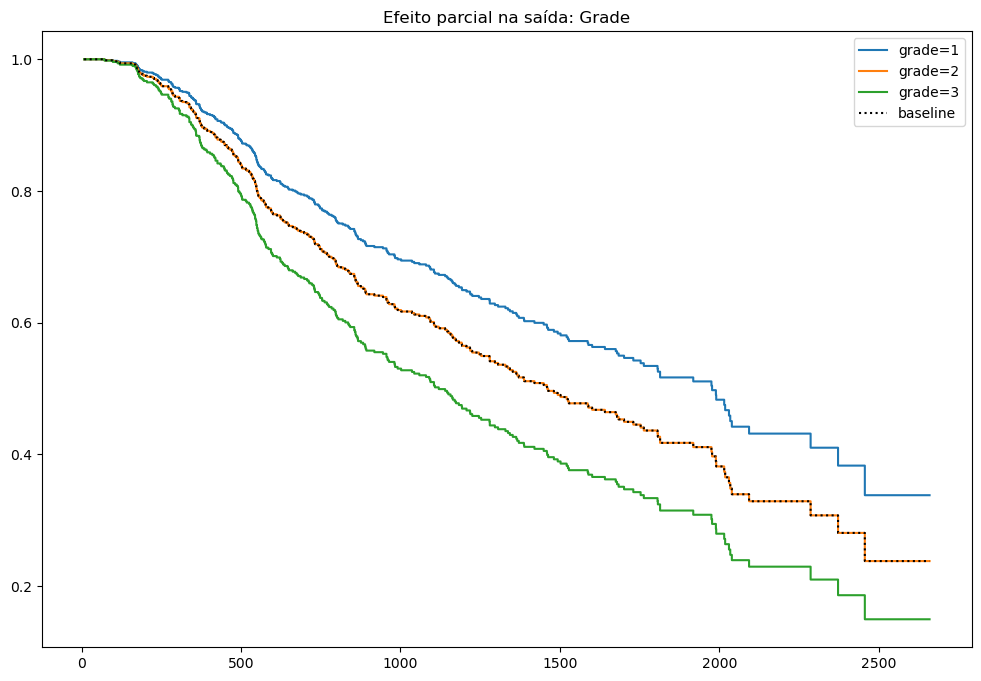

In [56]:
fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(1,1)
ax=fig.add_subplot(gs[0,0])

ax.set_title("Efeito parcial na saída: Grade")
cph.plot_partial_effects_on_outcome(covariates='grade', values=[1,2,3], ax=ax)
plt.show()
fig.savefig(f"images/cox/partial_grade.png")

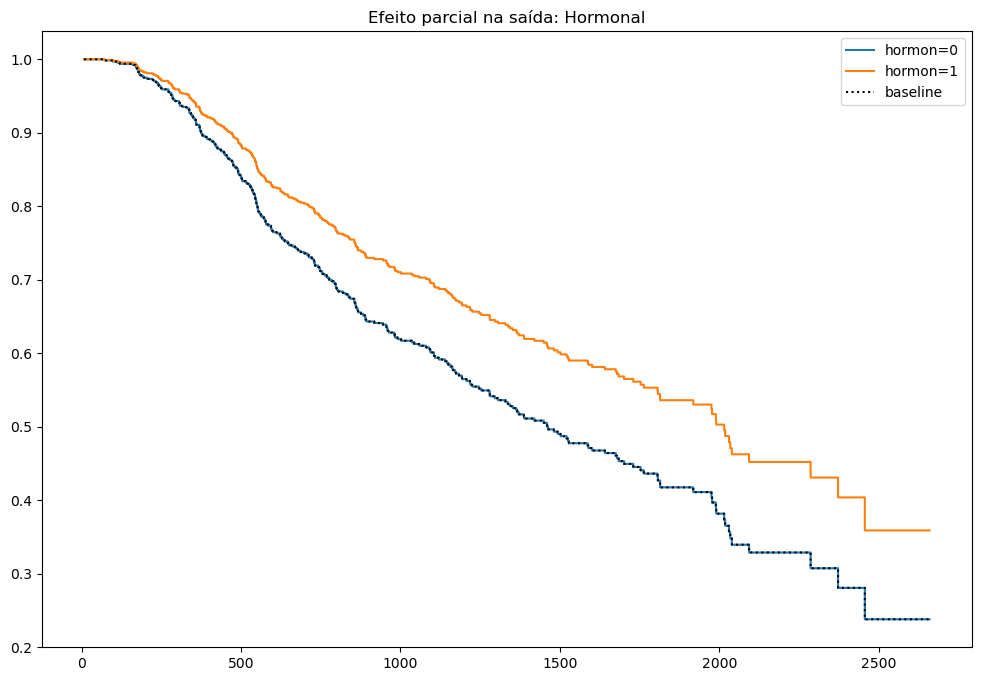

In [57]:
fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(1,1)
ax=fig.add_subplot(gs[0,0])

ax.set_title("Efeito parcial na saída: Hormonal")
cph.plot_partial_effects_on_outcome(covariates='hormon', values=[0,1], ax=ax)
plt.show()
fig.savefig(f"images/cox/partial_hormon.png")

### Estratificado



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.9977)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9183)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6121)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4584)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9482)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7545)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4668)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5636)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3536)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2471)'>]]

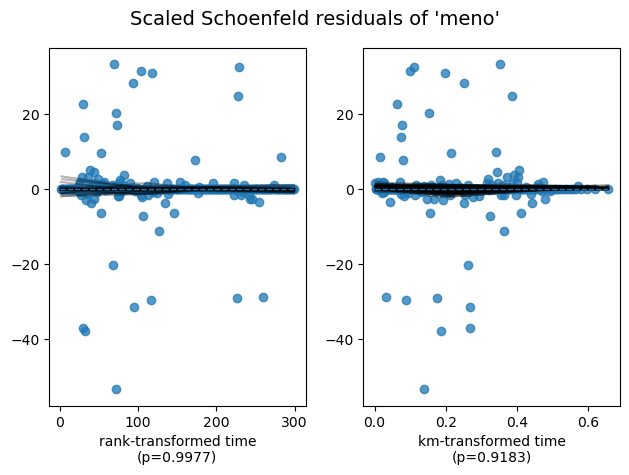

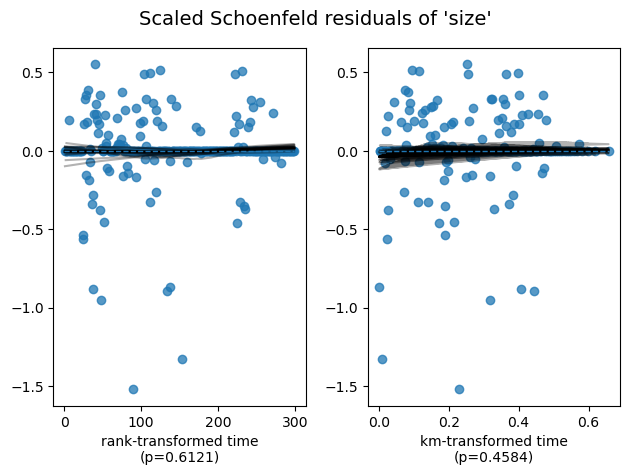

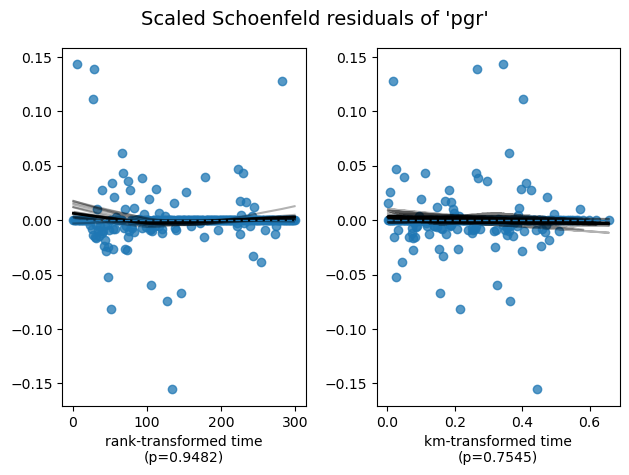

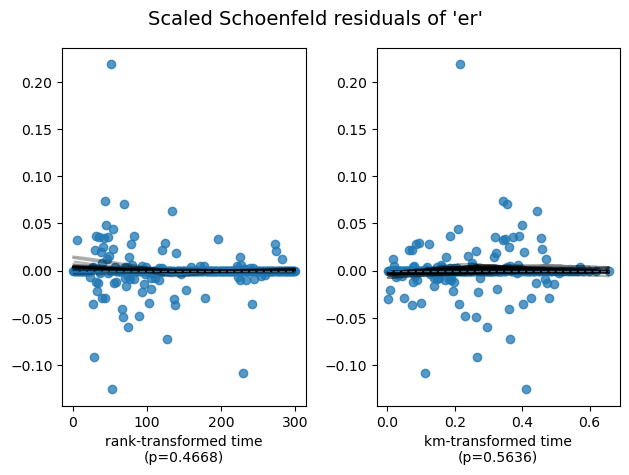

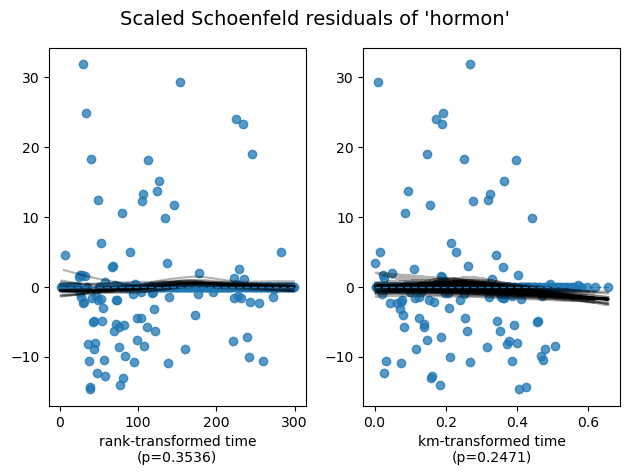

In [58]:
cph = CoxPHFitter()
cph.fit(df, duration_col='rfstime', event_col='status', strata=['grade','nodes','age'])
cph.check_assumptions(df, p_value_threshold=0.05, show_plots=True)

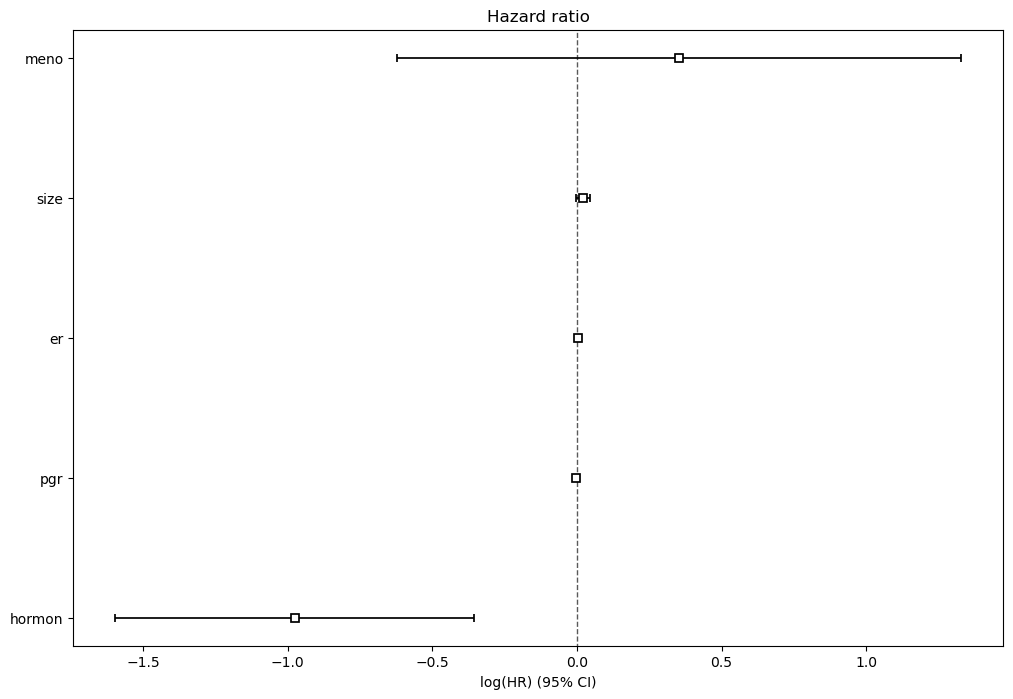

In [59]:
fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0,0])

ax.set_title("Hazard ratio")
cph.plot(ax=ax)
fig.savefig("images/cox/strat_all_features_hazard_ratios_strat.png")